# Coursework 2

Complete both tasks, using either a notebook or a Python script. Marks will be given for

* Correct implementation of algorithms to solve the tasks (10/20)
* Complete documentation of code, especially functions, and  **discussion** of results (6/20)
* Unit tests and/or code robustness through eg assertions, as appropriate (4/20)

## Agents - training the flock

A flock of boids is trained in small groups to find the "best" cohesion parameter $C$. This training is done by starting a flock of four boids at the locations $[0.5 \pm 0.25, 0.5 \pm 0.25]$ with initial velocities $[1, 1]$. The parameters $A = 5, S = 1/4$ are always used. The parameter $C$ is chosen to minimize the variance in the average width of the flock when they evolve up to $t=5$ with timesteps $\Delta t = 0.1$.

Once the flock is trained, we need to check the impact on a "proper" flock.

### Tasks

1. Given the training flock as above, use `scipy`'s `minimize_scalar` routine or equivalent to compute the best value of the parameter $C$ in the range $[0.1, 10]$. You may find the `numpy.var` routine useful for computing the variance.
2. Once you have trained the boids, create (as in the lab) a flock of $50$ agents randomly distributed within $[0, 5]^2$. Give them initial velocities of $(1, 1) + 10^{-2} {\bf v}_r$, where ${\bf v}_r$ is a random velocity with each component a uniform random number in $[0, 1]$. Evolve the flock using timesteps of $0.05$ for $200$ steps and plot the flock behaviour. Also plot the "width" of the flock.

In [1]:
# =============================================================================
# Simulation of a flock of boids where the cohesion parameter of the boids
# is studied in detail.
# =============================================================================

import timeit
import pytest
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize_scalar
from numba import jit
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (24, 12)

In [2]:
# =============================================================================
# Boid & Flock Classes
# =============================================================================

class Boid(object):
    """
    Constructs a boid which contains the boid's location and velocity.
    Functions in the class evolve's the boid's location and steer the boid
    due to the influence of it's neighbours.

    Class functions
    ---------------
    _step: Evolves the boid's location by a timestep dt using the Euler
        stepping method.
    _steer: Steers the heading of a boid by taking into account the influence
        of it's neighbours on a utilty function.
    """

    def __init__(self, location, velocity, C=1, A=5, S=0.25):
        """
        Creates an object boid which contains the coordinates and velocities
        for a boid. The Boid object also contains the utility function which
        is used to change the heading of a boid and is control by three
        parameters: C, A and S.

        Parameters
        ----------
        location: 1x2 array of floats.
            The 2D location of the boid.
        velocity: 1 x 2 array of floats.
            The 2D velocity of the boid.
        C: float.
            The cohesion parameter of the utilty function used to steer
            a boid. The cohesion controls how much a boid will steer towards
            the average location of a flock.
        A: float.
            The alignment parameter of the utility function used to steer a
            boid. The alignment controls how much a boid will steer towards
            the average heading of the flock.
        S: float.
            The separation parameter. The separation parameter controls how
            much a boid will steer to avoid crowding in the flock.
        """

        self._coords = np.array(location, dtype=np.float64)
        self._vel = np.array(velocity, dtype=np.float64)
        self._cost = (lambda theta, theta_z, theta_v, theta_zmin, delta_zmin:
                      - (C * np.cos(theta - theta_z) +
                         A * np.cos(theta - theta_v) -
                         S * np.cos(theta-theta_zmin)/delta_zmin ** 2))

    def _step(self, dt):
        """
        Compute a timestep for a boid to update it's position using the Euler
        stepping method.

        Parameters
        ----------
        dt: float. 
            The size of the timestep.
        """

        if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

        self._coords += dt * self._vel

    def _steer_boid(self, neighbours):
        """
        Compute a boid's new velocity due to the influence of the boid's
        neighbours in its immediate area.

        Parameters
        ----------
        neighbours: 1xN array of floats.
            N is the number of neighbours, where the neighbours in the array
            should be Boid objects.
        """

        N = len(neighbours)
        if N:  
            # record the location and velocities of the nighbours
            flock_locations = np.zeros((N, 2))
            flock_velocities = np.zeros((N, 2))
            for i, boid in enumerate(neighbours):
                flock_locations[i, :] = boid._coords
                flock_velocities[i, :] = boid._vel

            # average location and velocitiy of flock
            avg_coords = np.mean(flock_locations, axis=0)
            avg_vel = np.mean(flock_velocities, axis=0)

            # calculate angle parameters ======================================
            dz = avg_coords - self._coords       
            # direction to average location
            theta_z = np.arctan2(dz[1], dz[0])
            # direction of average velocity
            theta_v = np.arctan2(avg_vel[1], avg_vel[0])

            # direction and distance to closest neighbour =====================
            # disance of the boid from the other boids
            deltaz = flock_locations - self._coords
            # find the boid's closest neighbour
            z_min = deltaz[np.argmin(np.linalg.norm(deltaz, axis=1)), :]
            delta_zmin = np.linalg.norm(z_min)     # sep from nearest neighbour
            # calculate angles
            theta_dzmin = np.arctan2(z_min[1], z_min[0])   # angle to neighbour
           
            # calculate new angle for boid ====================================
            # use scipy.optmize.minimize to minimize the cost function to find
            # the optimum value of theta for the boid
            theta_min = minimize_scalar(self._cost, bounds=(-(3/2) * np.pi,
                                                             (3/2) * np.pi),
                                        args=(theta_z, theta_v, theta_dzmin,
                                              delta_zmin), method='bounded')

            # calculate new velocity vector
            vel_mag = np.linalg.norm(self._vel)
            self._vel[0] = vel_mag * np.cos(theta_min.x)
            self._vel[1] = vel_mag * np.sin(theta_min.x)


class Flock(object):
    """
    Constructs a flock of boids and provides functions to return data about the
    flock as well as a function to evolve the flock.

    Class functions
    ---------------
    _step: Computes a timestep for a flock by looking at each boid and
        finding it's neighbours.
    locations: Creates an array containing the locations of the all of the
        boids in a flock.
    _flock_average_location: Computes the centre of a flock by looking at the
        location of all the boids in a flock.
    _flock_width: Computes the average width of the entire flock.
    """

    def __init__(self, locations, velocities, C=1, A=5, S=0.25, rl=1):
        """
        Create a Flock object containing the location and velocities of the
        boids making up a flock.

        Parameters
        ----------
        locations: N x 2 array of floats.
            An array containing all of the (x, y) locations of each boid. N is
            the number of boids in the flock.
        velocities: N x 2 array of floats.
            An array containing all of the (Vx, Vy) velocities of each boid.
            N is the number of boids in the flock.
        C: float.
            The Cohesion parameter which controls how much a boid will steer
            towards the center of mass of a flock.
        A: float.
            The alignment parameter of the utility function used to steer a
            boid. The alignment controls how much a boid will steer towards the
            average heading of the flock.
        S: float.
            The separation parameter. The separation parameter controls how
            much a boid will steer to avoid crowding in the flock.
        rl: float.
            The looking radius of a boid, i.e. how far it can see and be
            affected by it's neighbouring boids.
        """

        if rl <= 0:
            raise ValueError('Boids are (hopfully) not blind, nor do they \
                             have a negative looking radius.')
        assert(len(locations) == len(velocities)), \
            'Supplied a different amount of Boid locations and velocities.'

        self._flockmate_locations = np.array(locations, dtype=np.float64)
        self._flockmate_velocities = np.array(velocities, dtype=np.float64)
        self._rl = rl  # rl is the looking radius, i.e. how far a boid can see
        self._boids = []  # list contaning all the boids in the flock
        for location, velocity, in zip(locations, velocities):
            self._boids.append(Boid(location, velocity, C, A, S))

        assert(len(self._boids) > 0), 'No boids in the flock :-('

    def _step(self, dt):
        """
        Compute a timestep where each agent will have it's velocity and
        location updated due to the influence of it's neighbours.

        Parameters
        ----------
        dt: float.
            The length of a time step to update a boid's position.
        """

        if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

        # create list of current agents at time step
        current_boids = []
        for agent in self._boids:
            current_boids.append(deepcopy(agent))

        # change the heading of the boid i in list _boids, i.e. all the boids
        for i, boid in enumerate(self._boids):
            # create list of neighbouring boids
            boid_neighbours = []
            for j, another_boid in enumerate(current_boids):
                if j != i:  # when another_boid != boid
                    sep = boid._coords - another_boid._coords
                    dist = np.linalg.norm(sep)
                    # if the boid is in the looking radis of the other
                    # boid, then it will be influenced by this boid so add it
                    # to the list of the boid's neighbours
                    if dist < self._rl:
                        boid_neighbours.append(another_boid)

            assert(len(boid_neighbours) <= len(current_boids)), \
                'A boid has more neighbours than there are boids in total.'

            # change the boid's heading due to the neighbours and compute
            # a timestep
            boid._steer_boid(boid_neighbours)
            boid._step(dt)

            # now update the positions of the boid in the locations array
            for i, boid in enumerate(self._boids):
                self._flockmate_locations[i, :] = boid._coords
                self._flockmate_velocities[i, :] = boid._vel

    def _flock_average_location(self):
        """
        Compute the centre of the flock by calculating the average location
        of all the boids in a flock. Requires there to be a list of all
        the boid locations in the flock.

        Returns
        -------
        A 1 x 2 array of floats cointaing the coordinates for the centre of the
        flock, using the average location of the boids.
        """

        return np.mean(self._flockmate_locations, axis=0)

    def _flock_width(self):
        """
        Compute the width of the flock by taking the average of the distance
        each boid is from the (average) centre of the flock.

        Returns
        -------
        A float value for the width of the flock.
        """

        sep = np.abs(self._flockmate_locations -
                     self._flock_average_location())

        return np.mean(np.linalg.norm(sep, axis=1))

In [3]:
# =============================================================================
# Training, Evolution & Plotting Functions
# =============================================================================

def training(C, locations, velocities, n_steps, dt):
    """
    Trains a small flock to find the best cohesion parameter, i.e. the best
    value of C to minimise the variance in the width of the flock.

    Parameters
    ----------
    C: float.
        The cohesion parameter to optimise.
    locations: N x 2 array of floats.
        The coordinate locations of the boids which are to be in the flock.
    velocities: N x 2 array of floats.
        The velocity components of the boids which are to be in the flock.
    n_steps: integer.
        The number of steps to take to evolve the flock.
    dt: float.
        The length of the timestep for each step.

    Returns
    -------
    variance: float.
        The variance of the width of the flock (the width as a function of
        time).
    """

    # define simulation parameters
    n_boids = len(locations)

    if n_boids == 0:
        raise ValueError('No boids in the flock :-(')
    assert(type(n_steps) == int), 'n_steps has to be an integer.'
    if n_steps <= 0:
        raise ValueError('Number of timesteps has to be greater than zero.')
    if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

    # there should be as many coordinates as velocities
    assert(len(locations) == len(velocities)), \
        'Supplied a different amount of Boid locations and velocities.'

    # create the flock
    flock = Flock(locations, velocities, C)

    # create arrays to store things
    locations = np.zeros((n_steps, n_boids, 2))
    average_width = np.zeros(n_steps)

    # set the first entries
    average_width[0] = flock._flock_width()

    # evolve the flock
    for step in range(1, n_steps):
        flock._step(dt)  # call the Flock stepping function
        average_width[step] = flock._flock_width()

    variance = np.var(average_width)

    # check to make sure the variance is sensible
    if variance < 0:
        raise ValueError('Negative variance: doesn\'t make sense.')
    elif variance == 0 and n_boids < 2:
        raise ValueError('Zero variance: the boids are moving, as such there \
                         should be some variance in the width of the flock, \
                         unless none of the boids can see one another.')

    return variance


def flock_evolution(locations, velocities, n_steps, dt, C=1):
    """
    Create a flock of boids and evolve it in time using the Euler stepping
    method to update it's position.

    Parameters
    ----------
    locations: N x 2 array of floats.
        The coordinate locations of the boids which are to be in the flock.
        N corresponds to the number of boids in the flock.
    velocities: N x 2 array of floats.
        The velocity components of the boids which are to be in the flock.
        N corresponds to the number of boids in the flock.
    n_steps: integer.
        The number of steps to take to evolve the flock.
    dt: float.
        The length of the timestep for each step.
    C: float.
        The cohesion parameter for the flock. This controls how much a boid
        will want to steer towards the centre of the flock.

    Returns
    -------
    locations: n_steps x N x 2 array of floats.
        The coordinate locations of the boids which have been evolved. N
        corresponds to the number of boids in the flock.
    average_width: n_steps x 1 array of floats.
        The average width of the flock at each time step.
    time_steps: n_steps x 1 array of floats.
        The corresponding value of time at the time steps.
    """

    # define simulation parameters, which is just the number of boids here
    n_boids = len(locations)

    # in the function evolve_flock_and_plot, these paramters are already
    # checked so this is mostly redundant and inefficent in that case, but if
    # this function is being called by itself, it's worthwhile keeping these
    # paramter checks in the function

    if n_boids == 0:
        raise ValueError('No boids in the flock :-(')
    assert(type(n_steps) == int), 'n_steps has to be an integer.'
    if n_steps <= 0:
        raise ValueError('Number of timesteps has to be greater than zero.')
    if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

    # there should be as many coordinates as velocities
    assert(len(locations) == len(velocities)), \
        'Supplied a different amount of Boid locations and velocities.'

    # create the flock
    flock = Flock(locations, velocities, C)

    # create arrays to store things
    locations = np.zeros((n_steps, n_boids, 2))
    width = np.zeros(n_steps)
    time_steps = np.zeros(n_steps)

    # set the first entries
    locations[0, :, :] = flock._flockmate_locations
    width[0] = flock._flock_width()

    # evolve the flock
    for step in range(1, n_steps):
        flock._step(dt)  # call the Flock stepping function
        locations[step, :, :] = flock._flockmate_locations
        width[step] = flock._flock_width()
        time_steps[step] = time_steps[step - 1] + dt

    return locations, width, time_steps

In [4]:
# =============================================================================
# Plotting Functions
# =============================================================================

def plot_flock(x, width, t, extra_filename=''):
    """
    Plot the locations of the boids in a flock and the width of the flock as
    a function of time.

    Parameters
    ----------
    x: n_steps x N x 2 array of floats.
        The locations of each boid in the flock at each time step, n_steps.
    width: n_steps x 1 array of floats.
        The width of the flock at each time step, n_step.
    t: n_steps x 1 array of floats.
        The value of time at each time step, n_step.
    extra_filename: string.
        Useful when plotting different things, but want to save the figure
        with a different name.

    Returns
    -------
    Two plots showing the initial positions of the boids, the postions of the
    boids as they evolved in time and the width of the flock as the flock
    evovled in time. The plots are output to the console as well as saved to
    the working directory.
    """

    assert(len(x) == len(t)), \
        'The size of the locations array has to be the same as the number of \
            time steps.'
    assert(len(width) == len(t)), \
        'The size of the width array has to be the same as the number of \
            time steps.'

    fig = plt.figure()

    fig.suptitle('{} Flock'.format(extra_filename))

    ax1 = fig.add_subplot(121)
    ax1.plot(x[:, :, 0], x[:, :, 1])
    ax1.plot(x[0, :, 0], x[0, :, 1], 'k*', label='Initial positions')
    ax1.plot(x[-1, :, 0], x[-1, :, 1], 'ko', label='Final positions')
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax1.set_title('Flock locations')
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(t, width)
    ax2.set_xlabel('Time, $t$')
    ax2.set_ylabel('Average Width')
    ax2.set_xlim(t[0], t[-1])
    ax2.set_title('Width of the flock')

    plt.savefig('flock_locations_width_{}.pdf'.format(extra_filename))
    plt.show()

In [5]:
# =============================================================================
# Flock Evolution
# =============================================================================

def train_flock(locations, velocities, n_steps, dt):
    """
    Constructs a flock of boids at pre-determined locations and evolves the
    flock by minimising the training_flock function. This function thus trains
    the boids and returns the value of C where the variance of the flock
    width wrt to time is the smallest. C is in the range [0.1, 10].

    Returns
    --------
    min_c.x: float.
        Returns the value computed in the minimize_scalar function, i.e. it
        returns the optimum value of C.
    """

    # get the size of the locations array to check if there are any boids
    n_boids = len(locations)

    # check that the simulation parameters make sense
    if n_boids == 0:
        raise ValueError('No boids in the flock :-(')
    assert(type(n_steps) == int), 'n_steps has to be an integer.'
    if n_steps <= 0:
        raise ValueError('Number of timesteps has to be greater than zero.')
    if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

    # there should be as many coordinates as velocities
    assert(len(locations) == len(velocities)), \
        'The dimensions of the locations and velocity arrays are different'

    # use minimize_scalar to minimize the output (the variance of the average
    # distance) of the training fuction
    min_c = minimize_scalar(training, bounds=(0.1, 10),
                            args=(locations, velocities, n_steps, dt),
                            method='bounded')

    return min_c.x


def evolve_flock_and_plot(locations, velocities, n_steps, dt, C, plot_name=''):
    """
    Simulates and then plots a flock of 50 random boids. The locations and
    velocities of the boids is returned so they can be used for comparisons.

    Parameters
    ----------
    locations: n_boids x 2 array of floats.
        The x and y locations of the boids in the flock, where n_boids is the
        number of boids.
    velocities: n_boids x 2 array of floats.
        The x and y velocities of the boids in the flock, where n_boids is the
        number of boids.
    n_steps: integer.
        The number of steps to evolve the flock for.
    dt: float.
        The size timestep for each n_step.
    C: float.
        The Cohesion parameter.

    Returns
    -------
    Returns a plot of the flock locations and the width of the flock.
    """

    # get the size of the locations array to check if there are any boids
    n_boids = len(locations)

    # check that the simulation parameters make sense
    if n_boids == 0:
        raise ValueError('No boids in the flock :-(')
    assert(type(n_steps) == int), 'n_steps has to be an integer.'
    if n_steps <= 0:
        raise ValueError('Number of timesteps has to be greater than zero.')
    if dt <= 0:
            raise ValueError('The timestep must be greater than zero.')

    # there should be as many coordinates as velocities
    assert(len(locations) == len(velocities)), \
        'The dimensions of the locations and velocity arrays are different'

    # call the function to evolve a flock
    flock_locations, flock_width, t = flock_evolution(locations,
                                                      velocities,
                                                      n_steps, dt, C)
    # plot the flock using the function
    plot_flock(flock_locations, flock_width, t, plot_name)

    print('Value of cohesion parameter, C: {}.'.format(C))

In [6]:
# =============================================================================
# Flock Generation
# =============================================================================

def training_boids():
    """
    Generate a simple flock of 4 boids for training purposes.

    Returns
    -------
    boid_locations: n_boids x 2 array of floats.
        An array containing a random x and y coordinates for n_boids.
    boid_velocities: n_boids x 2 array of floats.
        An array containing a random velocity x and y component for n_boids.
    """

    # create the 4 training boids
    boid_locations = np.array([[0.75, 0.75], [0.25, 0.25], [0.75, 0.25],
                               [0.25, 0.75]])
    boid_velocities = np.ones_like(boid_locations)

    assert(len(boid_locations) == len(boid_velocities)), \
        'The number of locations and velocities are not the same!'

    return boid_locations, boid_velocities


def random_flock(n_boids):
    """
    Generates a random flock of boids.

    Note: I'm going to make the assumption that the np.random.rand is not
    going to generate the same random number twice, so I will not be checking
    for duplicate positions

    Parameters
    ----------
    n_boids: integer.
        The number of boids to be in the flock.

    Returns
    -------
    boid_locations: n_boids x 2 array of floats.
        An array containing a random x and y coordinates for n_boids.
    boid_velocities: n_boids x 2 array of floats.
        An array containing a random velocity x and y component for n_boids.
    """

    assert(type(n_boids) == int), 'The number of boids has to be an integer.'
    if n_boids == 0:
        raise ValueError('No boids in the flock :-(')
    elif n_boids < 0:
        raise ValueError('A negative amount of boids is nonsense.')

    boid_locations = 5 * np.random.rand(n_boids, 2)
    boid_velocities = np.ones_like(boid_locations) + 0.01 * \
        np.random.rand(n_boids, 2)

    assert(len(boid_locations) == len(boid_velocities)), \
        'The number of locations and velocities are not the same!'
    assert(len(boid_locations) and len(boid_velocities) == n_boids), \
        'Wrong number of locations and velocities created.'

    return boid_locations, boid_velocities

In [7]:
# =============================================================================
# Test functions for flock_training
# =============================================================================

def test_functions(msg=False):
    
    print(' #### Beginning function tests ####\n')

    def test_boid_stepping_function(msg=False):
        """
        Tests that the function _step in the Boid class is working correctly.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # create a test boid with some velocity
        test_boid = Boid([1, 1], [1, 0.5], 1)

        # test to make sure the stepping function is returning a ValueError when
        # it is given a negative or zero timestep.
        # the test will pass if a ValueError is raised
        with pytest.raises(ValueError):
            test_boid._step(-5)
            test_boid._step(0)

        # test that the stepping function will return the expected value given
        # the locations, velocities and a timestep.
        # expecting the locations to be incremented by dt * v as the new updated
        # locations are x + dt * v which will be x + 0.1 with dt = 0.1 and v = 1.
        # testing with different velocities in each component to make sure both
        # components are updated independentally
        test_boid._step(0.1)

        assert(test_boid._coords[0] == 1.1), \
            'Time step function for boid isn\'t working'
        assert(test_boid._coords[1] == 1.05), \
            'Time step function for boid isn\'t working'

        # check that a boid's position isn't changed if it's stationary
        stationary_boid = Boid([1, 1], [0, 0], 1)
        stationary_boid._step(1)
        assert(np.all(stationary_boid._coords == [1, 1])), \
            'The boid is moving when it has no velocity.'

        if msg == True:
            print('Boid _step function testing passed.')        

    def test_flock_positions_and_velocities(msg=False):
        """
        Tests to see if the flock of boids is being set up correctly, i.e. that
        the location and velocities of the boids are in the correct order. Tests
        the _flockmate_locations and _flockmate_velocities functions in the Flock
        class.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # check to see if the Flock is being set up correctly
        boid_locations = [[1, 1.6], [1.5, 11]]
        boid_velocities = [[1.111111, 333], [0, 23]]
        test_flock = Flock(boid_locations, boid_velocities)

        # expecting the first list to be the first row in the flock location
        # array and expecting the elements to not be muddled up.
        # check that the location of the boids are being appended to the flockmate
        # locations list correctly
        assert(np.all(test_flock._flockmate_locations[0, :] ==
                      boid_locations[0])), \
            'Flockmates being added to location array incorrectly'
        assert(np.all(test_flock._flockmate_locations[1, :] ==
                      boid_locations[1])), \
            'Flockmates being added to location array incorrectly'
        # check that the velocities of the boids are being added to the
        # flockmate velocities array correctly
        assert(np.all(test_flock._flockmate_velocities[0, :] ==
                      boid_velocities[0])), \
            'Flockmates being added to location array incorrectly'
        assert(np.all(test_flock._flockmate_velocities[1, :] ==
                      boid_velocities[1])), \
            'Flockmates being added to location array incorrectly'
        
        if msg == True:
            print('Flock location and velocity array testing passed.')           

    def test_flock_step(msg=False):
        """
        Test the flock stepping function _step in the Flock class.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # create flock where two boids will see each other
        boid_locations = [[1, 1.6], [1.5, 1]]
        boid_velocities = [[1.3, 1.2], [1.8, 0.4]]
        test_flock = Flock(boid_locations, boid_velocities)

        # the two boids in the above flock should see each other and so should
        # evolve. Thus, calling the Flock _step function on them should see that
        # their positions and velocities change
        int_locs = deepcopy(test_flock._flockmate_locations)
        int_vels = deepcopy(test_flock._flockmate_velocities)
        test_flock._step(0.01)
        assert(np.any(test_flock._flockmate_locations != int_locs)), \
            'The flock should have changed, but it hasn\'t.'
        assert(np.any(test_flock._flockmate_velocities != int_vels)), \
            'The flock should have changed, but it hasn\'t.'

        # test flock where two boids can't see one another
        boid_locations = [[1, 1.6], [3.4, 3.7]]
        boid_velocities = [[3.3, 3.2], [1, 1]]
        test_flock = Flock(boid_locations, boid_velocities)

        # the two boids can't see each other as they are outside the looking radius
        # thus their direction should remain unaffected and they will travel in a
        # straight line
        new_location = deepcopy(test_flock._flockmate_locations) + 0.1 * \
            deepcopy(test_flock._flockmate_velocities)
        int_vels = deepcopy(test_flock._flockmate_velocities)
        test_flock._step(0.1)

        assert(np.all(test_flock._flockmate_locations == new_location)), \
            'The boids should move in a straight line, but haven\t.'
        assert(np.all(test_flock._flockmate_velocities == int_vels)), \
            'The boid\'s velocities have changed even though they shouldn\'t.'
       
        if msg == True:
            print('Flock _step function testing passed.')          

    def test_small_flocks(msg=False):
        """
        Runs tests on small flocks to test if the ouput for these flocks is as
        expected. These tests will test the _step function in the Flock class,
        where the flocks are generated and the neighbours are found. The function
        _steer_boid for Boid is also included in the Flock _step function and thus
        this test function will also test that the _steer function is functioning
        as expected.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # create a flock where two boids can't see each other, so they should not
        # influence each other's paths and thus just travel in a straight line
        distant_boids = Flock([[0, 0], [2, 2]], [[1, 1], [1, 1]])
        distant_boids._step(0.1)
        assert(np.all(distant_boids._flockmate_locations[0, :] == 0.1))
        assert(np.all(distant_boids._flockmate_locations[1, :] == 2.1))

        # create a flock where two boids are very close. This means that the first
        # boid should steer away from boid 2, i.e. it's velocity should be less
        # than (or) zero as it has turned around from its original velocity.
        # Boid 2's velocity should remain in the same direction, has boid 1 has
        # already turned around
        close_boids = Flock([[0, 0], [0.001, 0.0]], [[1, 0], [1, 0]])
        close_boids._step(0.1)
        assert(np.all(close_boids._flockmate_locations[0, :] <= 0))

        # create a flock where one boid is moving very fast. This boid should move
        # fast enough in the timestep that it is outside of the viewing radius of
        # the boid before and after and so the slow boid will not be influenced by
        # the fast boid as it doesn't have enough time (or timestep resolution) to
        # react to the fast boid
        fast_boid = Flock([[0, 0], [1.5, 0.0]], [[1, 0], [100, 0]])
        int_locs = fast_boid._flockmate_locations
        int_vels = fast_boid._flockmate_velocities
        new_locs = int_locs + 0.1 * int_vels
        fast_boid._step(0.1)
        assert(np.all(fast_boid._flockmate_locations == new_locs)), \
            'Slow boid should have been unaffected by fast boid.'
        assert(np.all(fast_boid._flockmate_velocities == int_vels)), \
            'The slow and fast boid velocities should be unaffected.'

        # create a flock of stationary boids and evolve for one timestep. The boids
        # shouldn't move even if the boid has neighbours.
        stationary_flock = Flock([[1, 1], [1.5, 1.5]], [[0, 0], [0, 0]])
        int_locs = stationary_flock._flockmate_locations
        stationary_flock._step(0.1)
        assert(np.all(stationary_flock._flockmate_locations == int_locs)), \
            'The boids have moved even when they have no velocity.'

        if msg == True:
            print('Flock testing on small flocks passed.')          

    def test_flock_average_location(msg=False):
        """
        Tests the _flock_average_location function in the Flock class.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # put two boids on top of each other. Not realistic at all, but expecting
        # the function to return the position which both boids occupy. In practice
        # the boids shouldn't end up in this situation, as they should steer away
        # from each other, but it's a simple test either way.
        pauli_violated = Flock([[1, 1], [1, 1]], [[1, 1], [1, 1]])
        assert(np.all(pauli_violated._flock_average_location() == 1))

        # test the mean function for a bigger and more realistic flock. The value
        # of the class function should match the values of x_avg and y_avg which
        # are calculated below
        flock_locations = np.array([[1, 1], [1.3, 1.5], [2, 1.3], [0.4, 0.9],
                                   [5, 2]])
        flock_vels = np.ones(5)
        test_flock = Flock(flock_locations, flock_vels)
        x_avg = np.sum(flock_locations[:, 0]) / 5
        y_avg = np.sum(flock_locations[:, 1]) / 5
        assert(np.all(test_flock._flock_average_location() ==
                      np.hstack((x_avg, y_avg)))), \
            'Average of the flock locations is being calculated incorrectly.'

        if msg == True:
            print('Flock _flock_average_location function testing passed.')           

    def test_flock_width(msg=False):
        """
        Tests the _flock_width function in the Flock class.
        
        Parameters
        ----------
        msg: boolean. If msg is set to True, a message showing that this test
            has passed will be printed to the console.
        """

        # create a flock
        flock_locations = np.array([[1, 1], [1.3, 1.5], [2, 1.3], [0.4, 0.9],
                                   [5, 2]])
        flock_vels = np.ones(5)
        test_flock = Flock(flock_locations, flock_vels)
        # calculate the average location of the flock
        average_location = (np.sum(flock_locations[:, 0]) / 5,
                            np.sum(flock_locations[:, 1]) / 5)
        # calculate a the separation of the flockmates from the average location
        # of all the boids in a flock and then calculate the euclidian distance
        # from the average location of the boids
        test_flock_sep = np.abs(test_flock._flockmate_locations -
                                average_location)
        test_flock_r = np.sqrt(np.sum(test_flock_sep ** 2, axis=1))
        # the average width is then the average of these distances
        flock_width = np.mean(test_flock_r)
        # expecting a value of around 1.3 for flock_width. This is due to the
        # average location of the flock being (1.94, 1.34). Thus when the locations
        # are subtracted and then the mean of those values are found, the value of
        # around 1.3 appears

        # now test the hand calculated values against the function
        assert(np.all(flock_width == test_flock._flock_width()))
        
        if msg == True:
            print('Flock _flock_width function testing passed.')

    test_boid_stepping_function(msg)
    test_flock_positions_and_velocities(msg)
    test_flock_step(msg)
    test_small_flocks(msg)
    test_flock_average_location(msg)
    test_flock_width(msg)
        
    print('\n#### Function tests successful ####')

 #### Beginning function tests ####

Boid _step function testing passed.
Flock location and velocity array testing passed.
Flock _step function testing passed.
Flock testing on small flocks passed.
Flock _flock_average_location function testing passed.
Flock _flock_width function testing passed.

#### Function tests successful ####


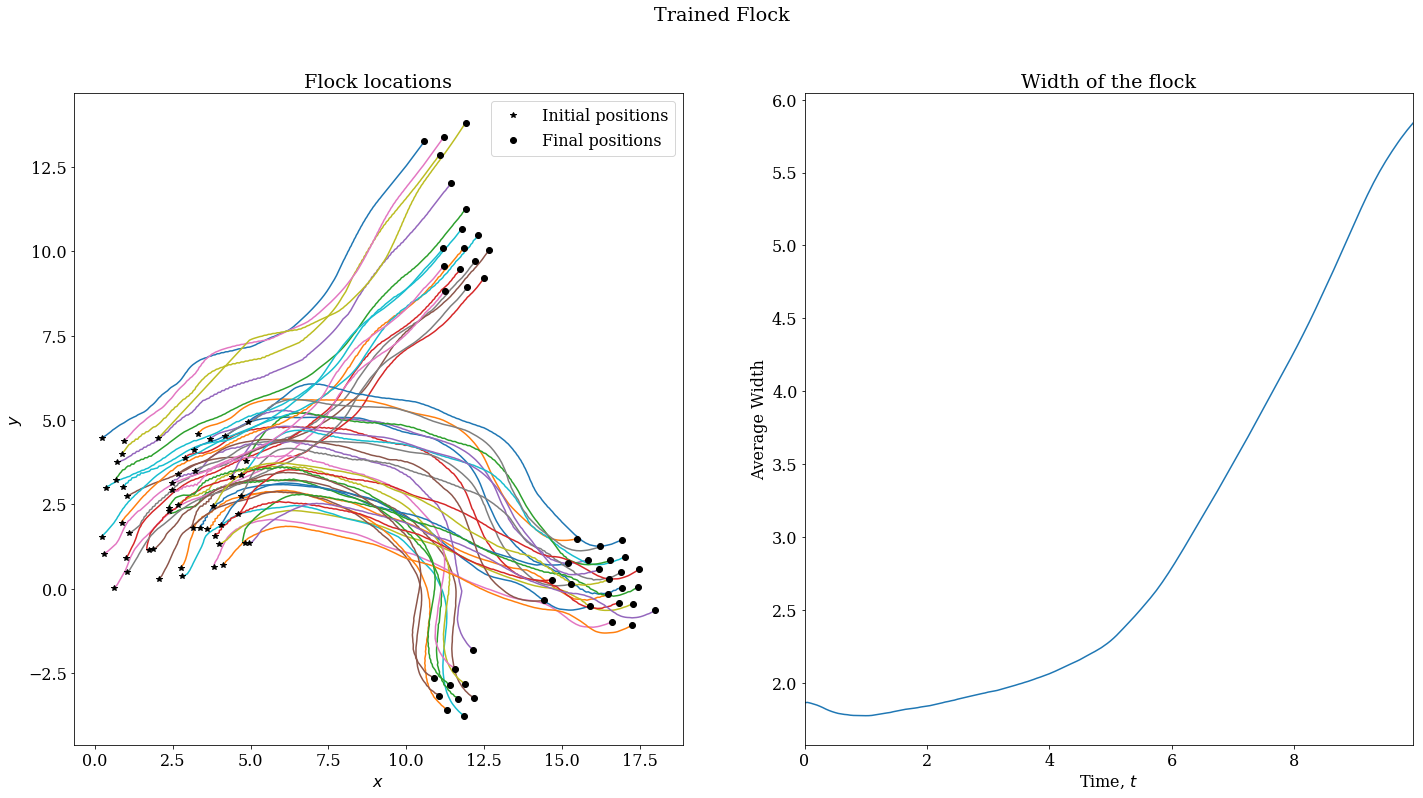

Value of cohesion parameter, C: 0.74430900360855.
Run time:   6.92 seconds.


In [8]:
# =============================================================================
# Run the functions and etc
# =============================================================================

# only runs a flock simulation if the interpreter is running the file as the
# main program. This helps with testing using pytest so the code doesn't run
# multiple times when imported to the testing script

if __name__ == "__main__":
    # call pytest in quiet mode, should only make a noise if a test fails
    # pytest.main(['-q', /path/to/test/file/])  # I'm not really sure how pytest works in a notebook
    test_functions(msg=True)  # prints messages to show that a test has passed
    
    start = timeit.default_timer()  # start  run timer
    
    # train the flock
    training_loc, traning_vel = training_boids()
    training_n_steps = 50
    training_dt = 0.1
    C = train_flock(training_loc, traning_vel, training_n_steps, 
                    training_dt)  

    # apply the training to a flock
    n_boids = 50
    random_loc, random_vel = random_flock(n_boids)
    n_steps = 200
    dt = 0.05
    evolve_flock_and_plot(random_loc, random_vel, n_steps, dt, C, 'Trained')
    
    stop = timeit.default_timer()  # end run timer

    print('Run time: {:6.2f} seconds.'.format(stop - start))

# Discussion

## Changing the value of C with the training flock

** The variance in the flock width is expected to change with different values of the cohesion parameter *C* Below are plots of how different values of C affect the training flock.**.

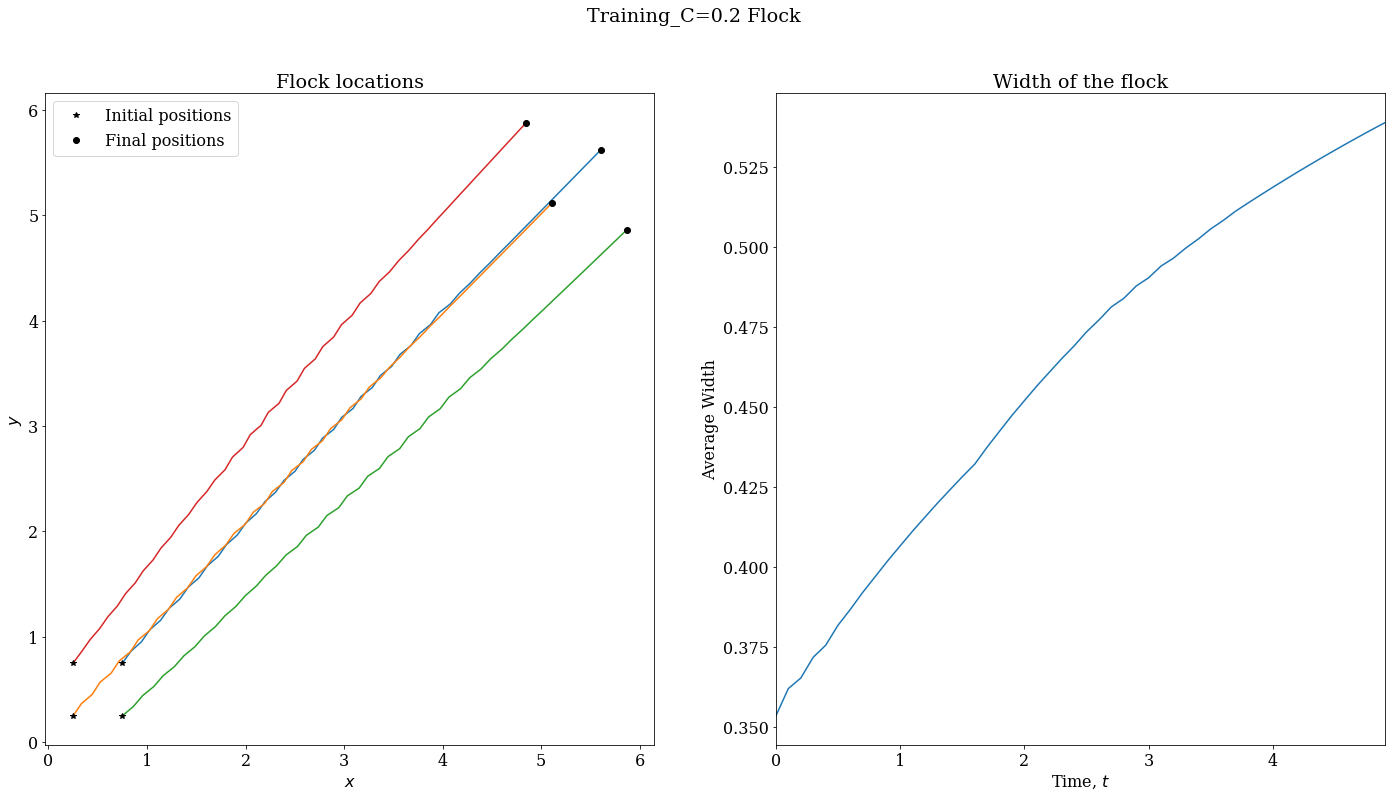

Value of cohesion parameter, C: 0.2.


In [9]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 0.2, 'Training_C=0.2')

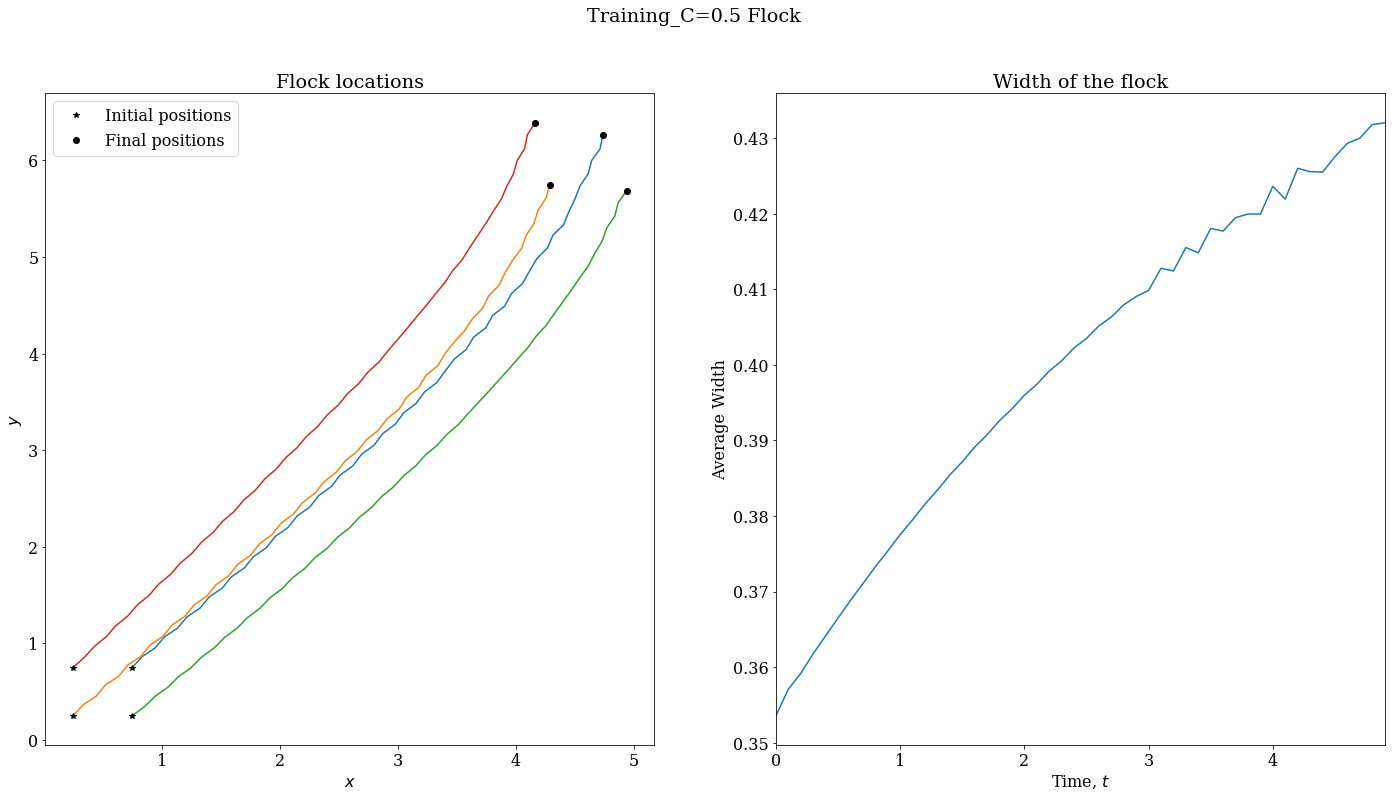

Value of cohesion parameter, C: 0.5.


In [10]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 0.5, 'Training_C=0.5')

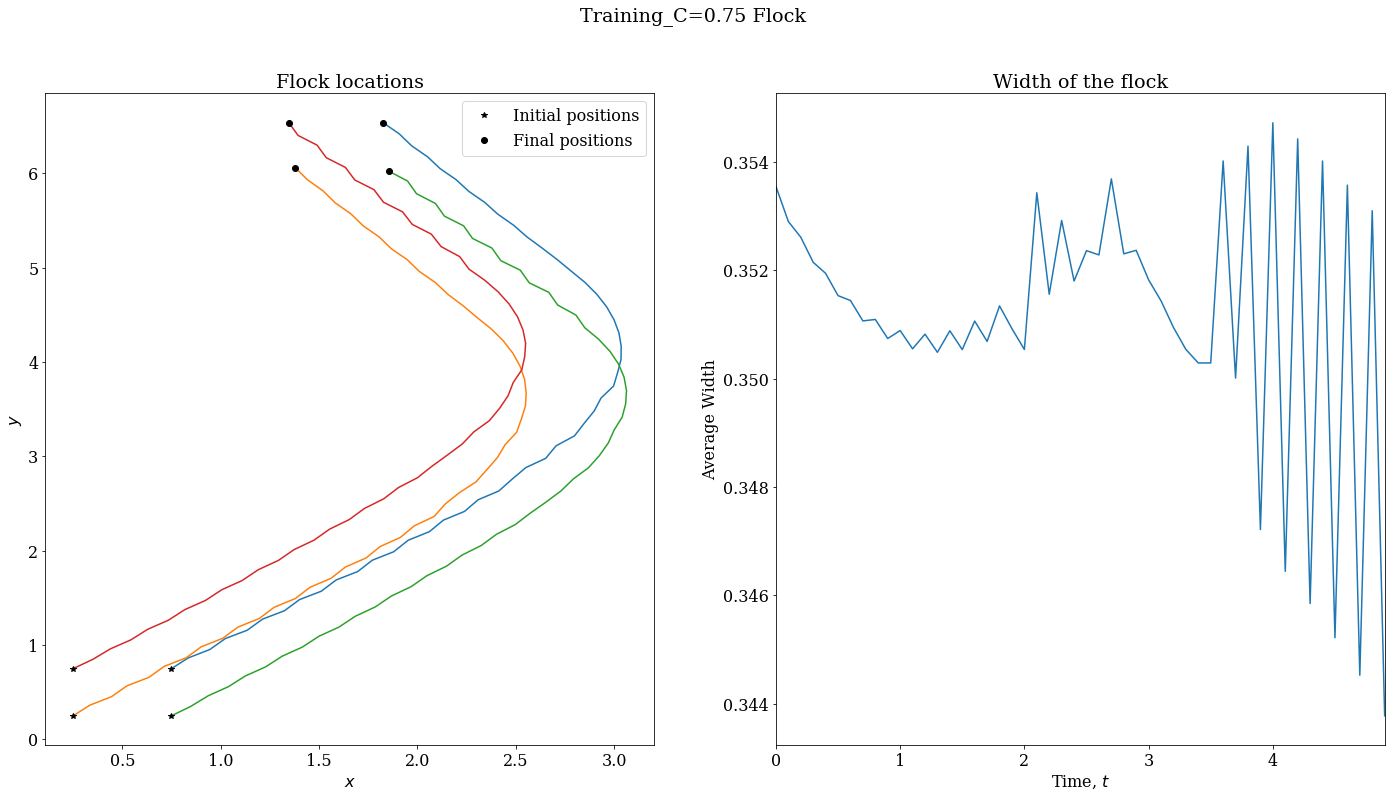

Value of cohesion parameter, C: 0.75.


In [11]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 0.75, 'Training_C=0.75')

** Increasing the value of C causes the boids to steer towards the flock more, where at the optimum C value of around 0.75, the boid's steering is subtle enough that the variance in the flock width is low. Boids don't seem to steer towards each other until C is a critcal value.**

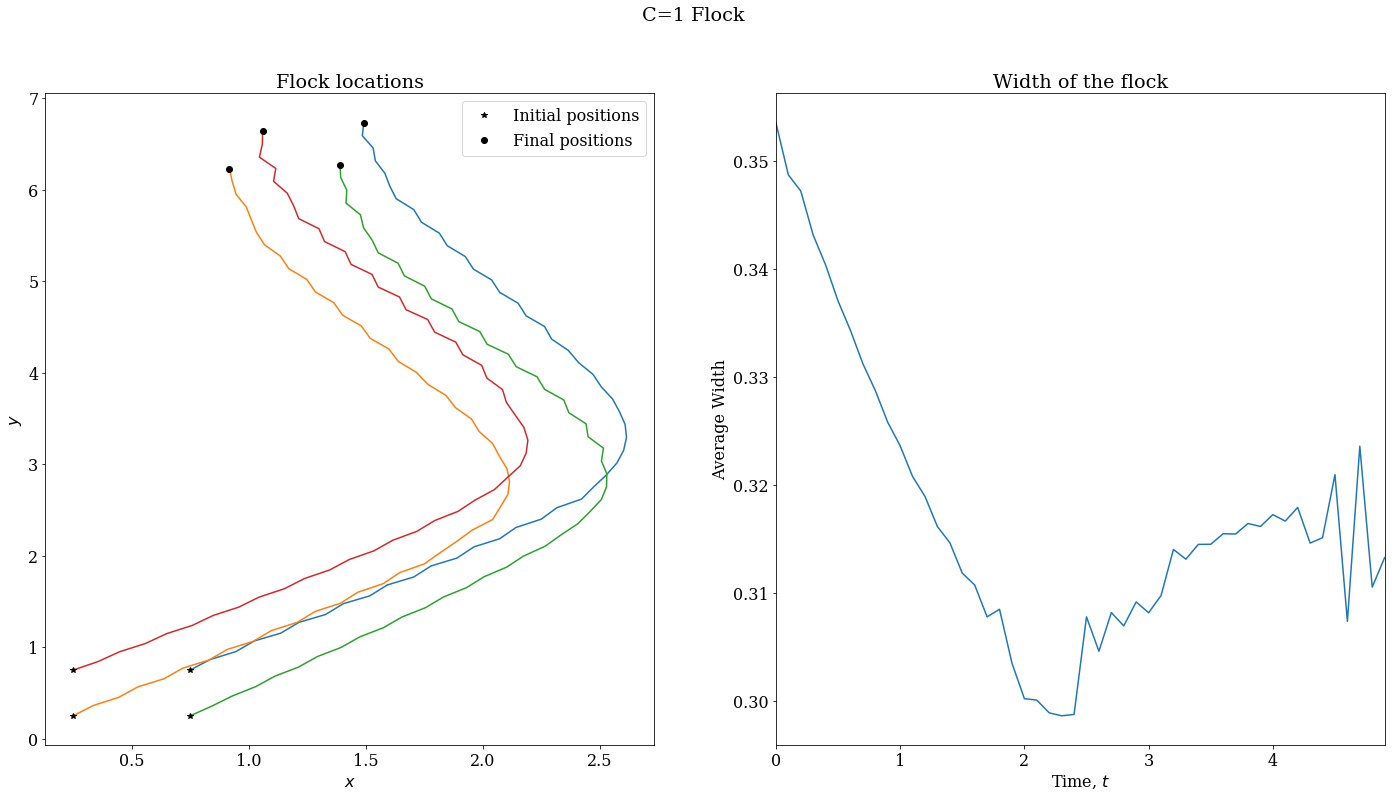

Value of cohesion parameter, C: 1.


In [12]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 1, 'C=1')

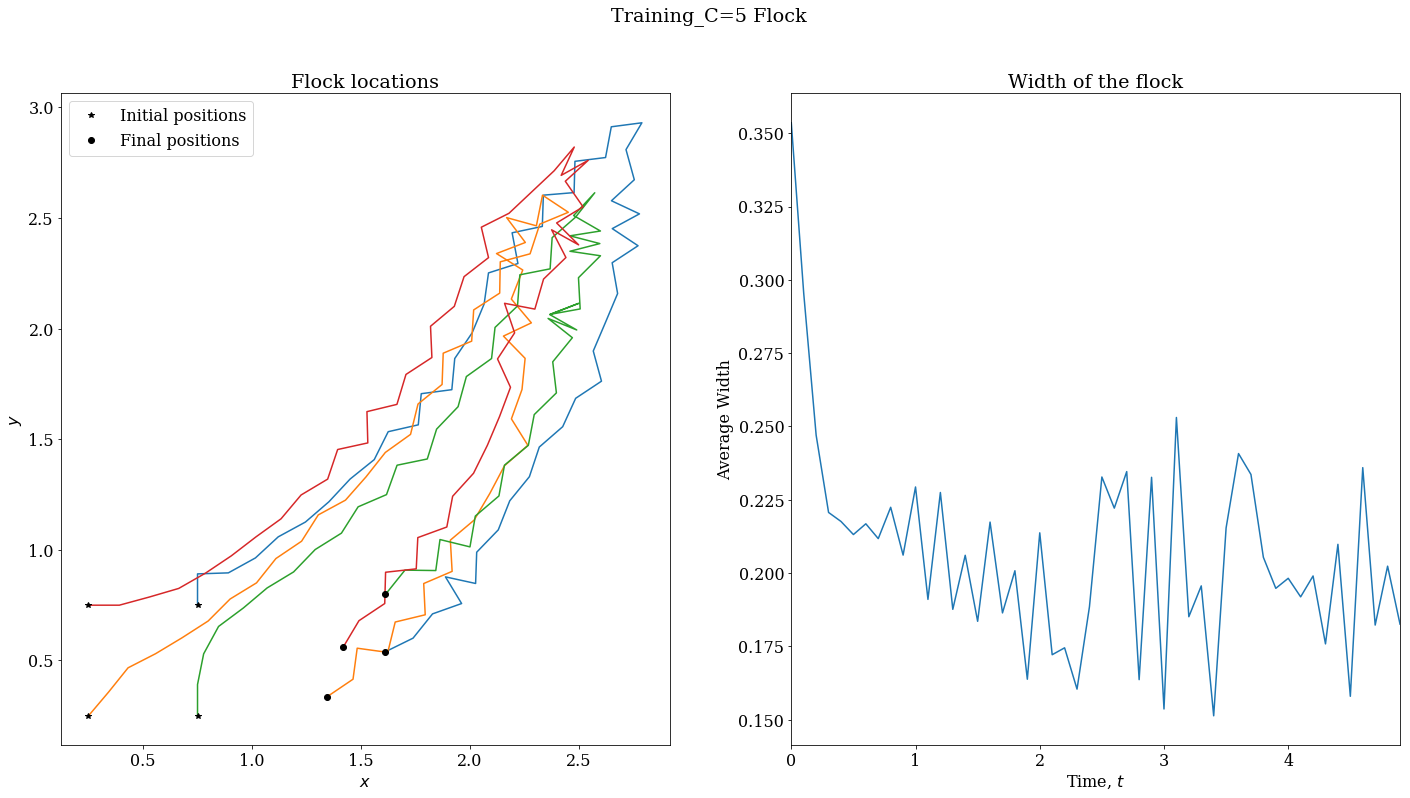

Value of cohesion parameter, C: 5.


In [13]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 5, 'Training_C=5')

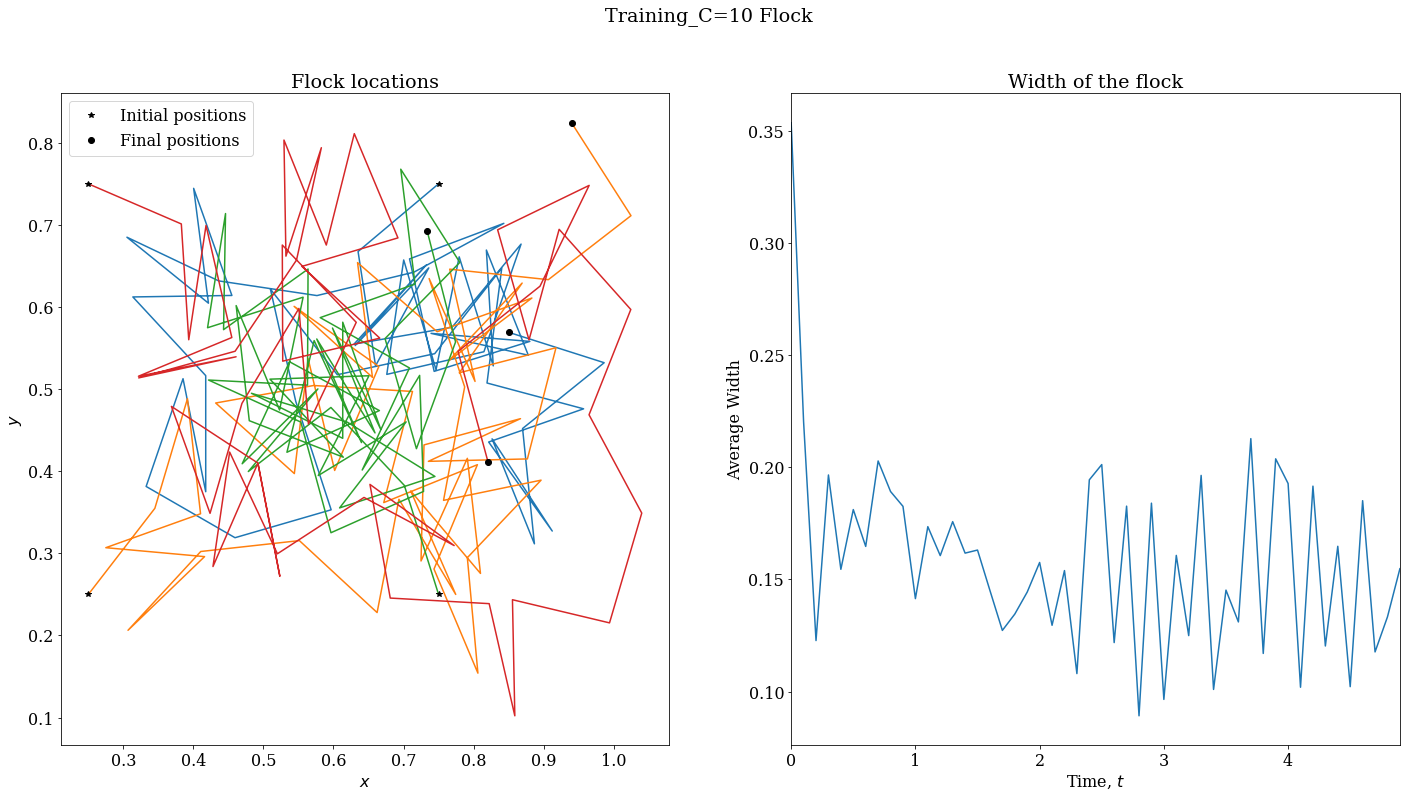

Value of cohesion parameter, C: 10.


In [14]:
evolve_flock_and_plot(training_loc, traning_vel, 50, 0.1, 10, 'Training_C=10')

** However, as C is increased the boids begin to steer more aggressively and their paths oscillate as they steer towards the flock but are pushed back by the utility function to avoid clumping. In general, increasing C causes the flock separation to become lower, but slowly increases the variance in the flock width. **

## Changing the value of C on a larger flock

** I'll print the original trained flock from above again. **

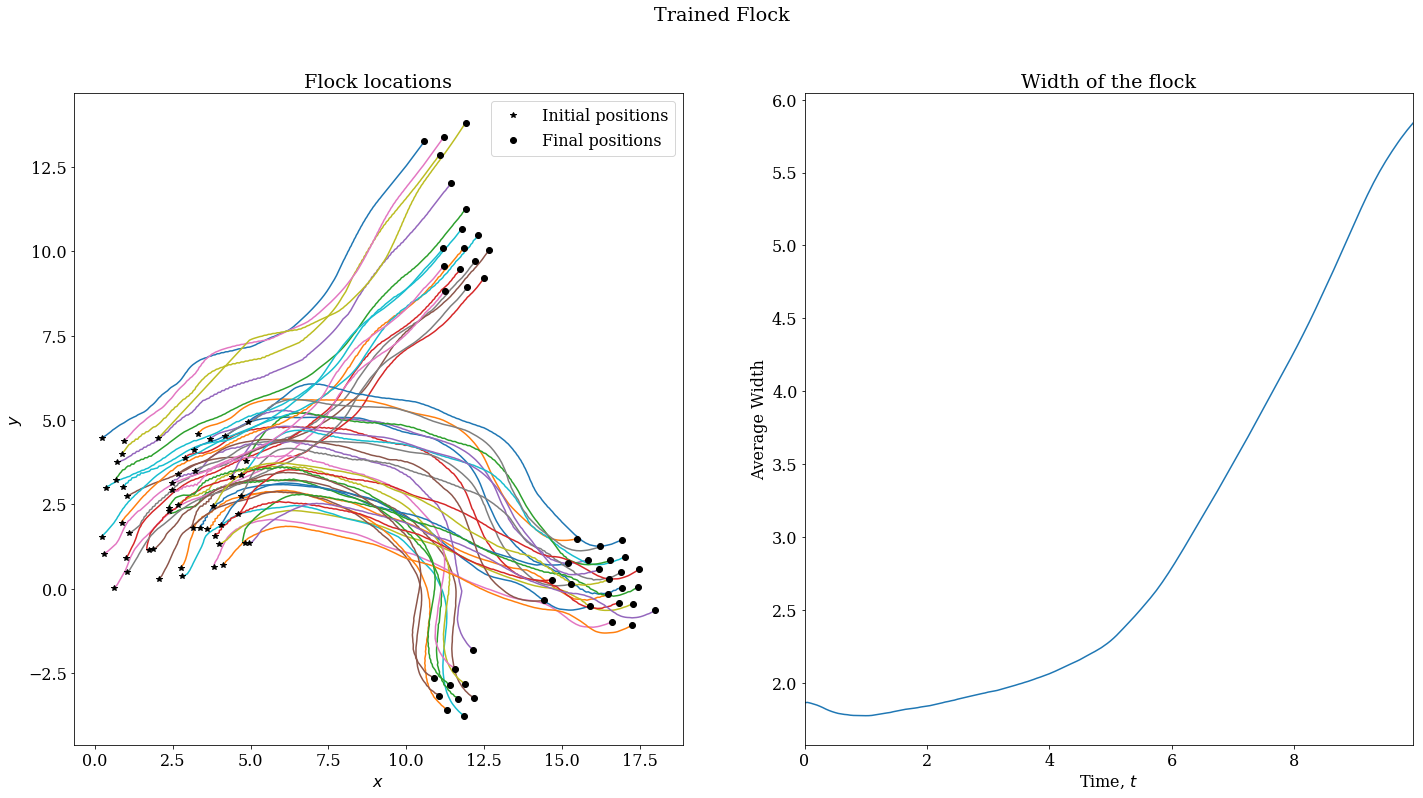

Value of cohesion parameter, C: 0.74430900360855.


In [15]:
evolve_flock_and_plot(random_loc, random_vel, 200, 0.05, C, 'Trained')

** Now I'll look at values of C lower and higher than the minimised value of C. **

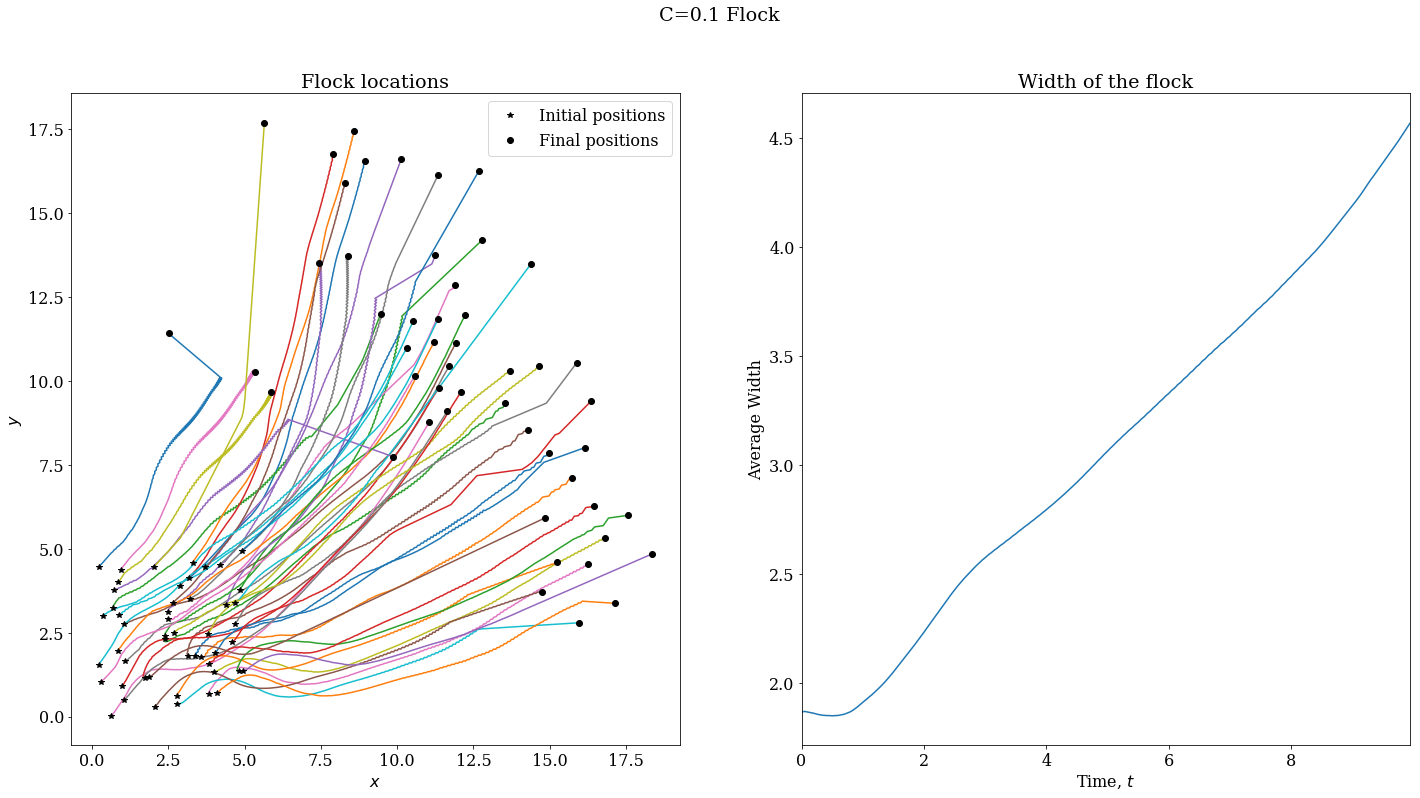

Value of cohesion parameter, C: 0.1.


In [16]:
evolve_flock_and_plot(random_loc, random_vel, 200, 0.05, 0.1, 'C=0.1')

** Here the boids do not steer strongly towards the flock central location and it appears that the boids are moving outwards. ** 

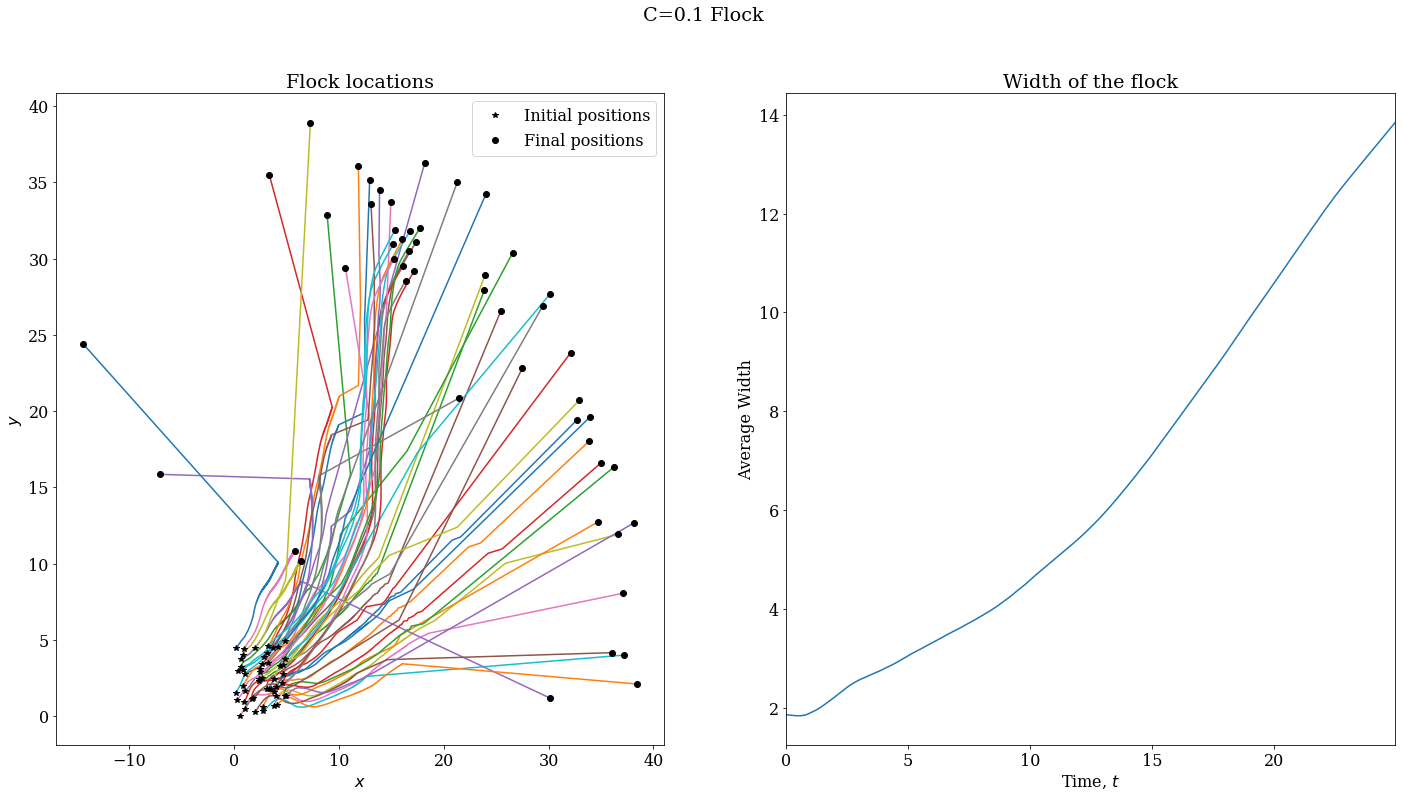

Value of cohesion parameter, C: 0.1.


In [17]:
evolve_flock_and_plot(random_loc, random_vel, 500, 0.05, 0.1, 'C=0.1')

** Running for longer shows that some of the boids split apart and the width of the flock is getting larger. **

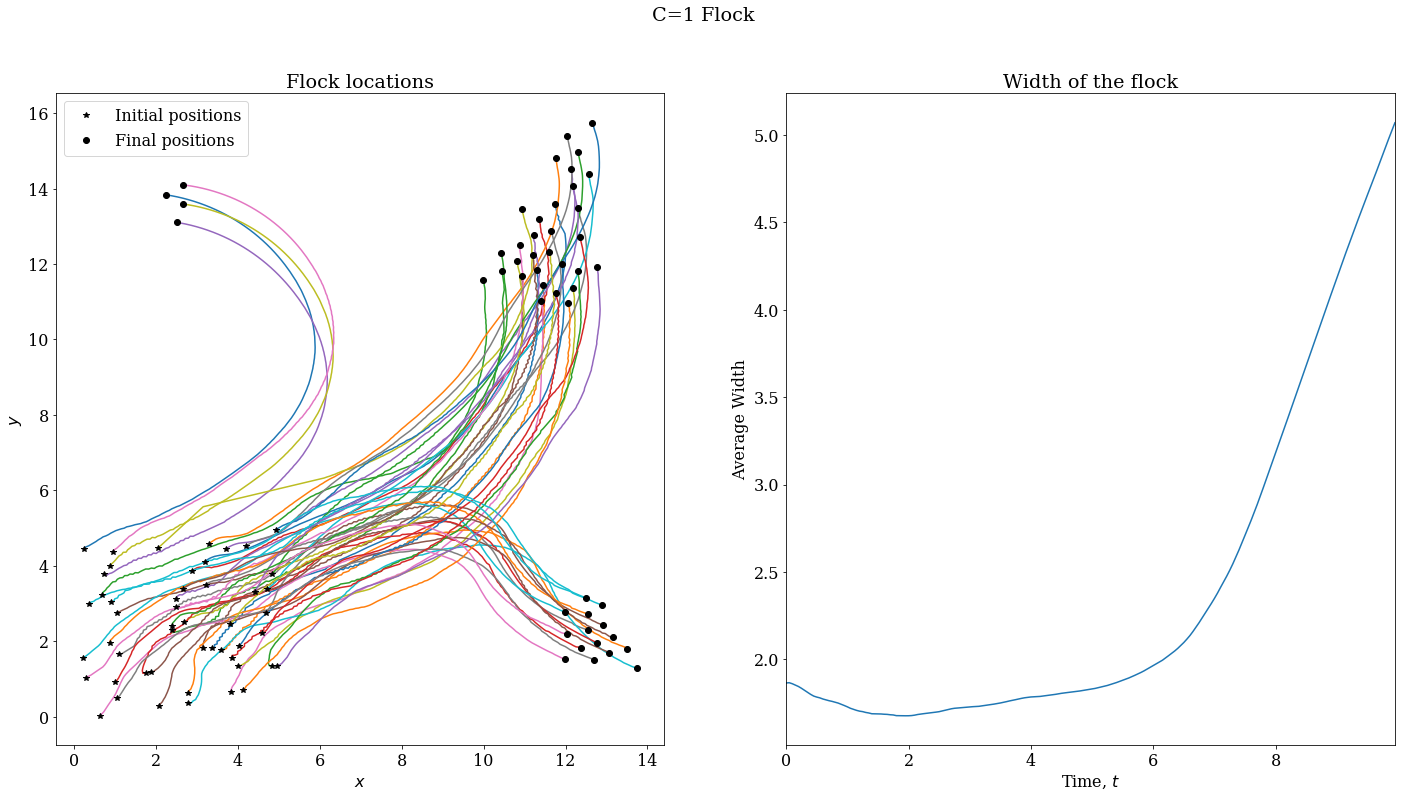

Value of cohesion parameter, C: 1.


In [18]:
evolve_flock_and_plot(random_loc, random_vel, 200, 0.05, 1, 'C=1')

** The flock splits off into separate flocks here. This would be due to the edges of the flock being denser packed than the middle, so the boids in these dense regions went off together as the larger C caused them to steer more towards the centre of a flock. **

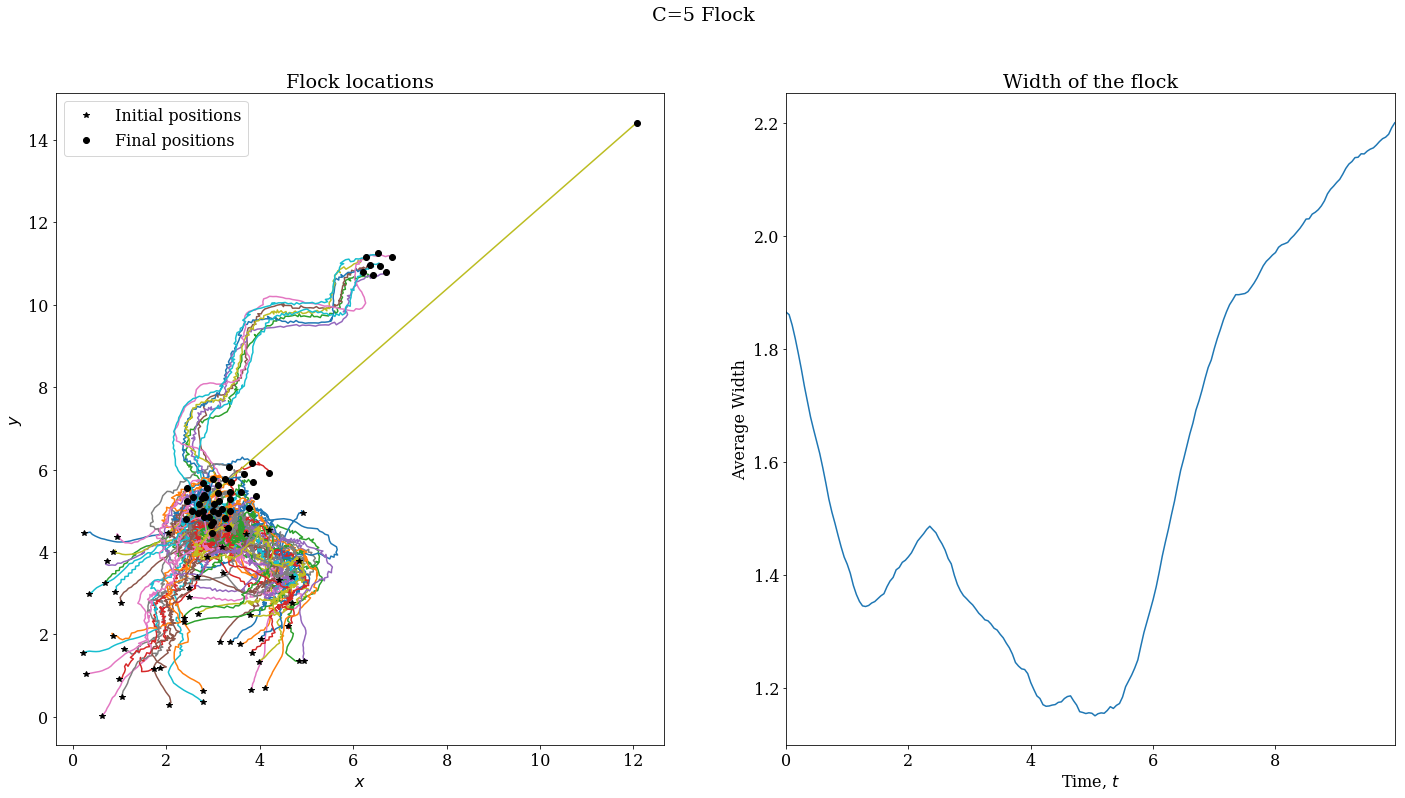

Value of cohesion parameter, C: 5.


In [19]:
evolve_flock_and_plot(random_loc, random_vel, 200, 0.05, 5, 'C=5')

** When C is increased, and becomes too large, the boids steer aggressively towards the centre of the flock. This results in some form of boid mosh pit for most of the boids. However, the boids on the were able to escape this fate. There was also one lonely boid who never saw anybody, probably due to other boids steering aggressively towards the flock centre moving out of the looking radius for this boid. **

# Plotting Flock Width Variance against C

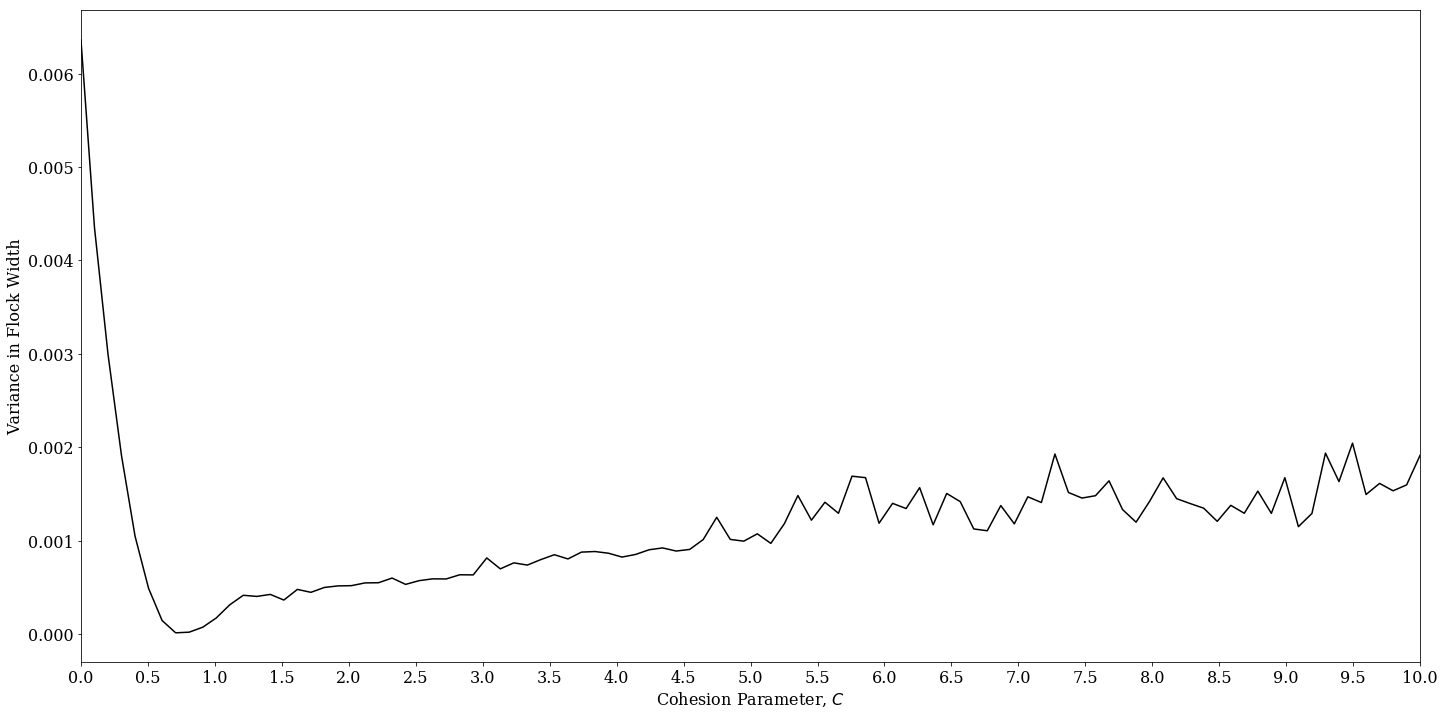

In [20]:
Cs = np.linspace(0, 10, 100)
var = np.zeros_like(Cs)
for i, C in enumerate(Cs):
    var[i] = training(C, training_loc, traning_vel, 50, 0.1)

plt.plot(Cs, var, 'k-') 
plt.xticks(np.arange(0, 10.5, 0.5))
plt.xlim(0, 10)
plt.xlabel('Cohesion Parameter, $C$')
plt.ylabel('Variance in Flock Width')
plt.show()

**There is a global minimum around 0.8, which will return the lowest variance in the flock width. However, there are other local minimum's in the function as well which the minimize_scalar can converge towards depending on the boundaries. These local minimums could potentially cause issues depending on the method used in minimize_scalar, but the bounded method returned the global minimum, but likely because this was the first minimum it enocuntered. It is probably a good idea to plot this for a training flock and then choose appropriate bounds to find the global minimum.**

** The plot also shows that the variance in the flockwidth rapidly drops as C goes towards ~0.75, but then after this value of C, the variance in the flock slowly increases. **

# Does the resolution of the timesteps change the variance?

In [21]:
# alart, this takes long to run
low_c = train_flock(training_loc, traning_vel, 50, 0.1)
med_c = train_flock(training_loc, traning_vel, 50, 0.01)
med_c_long = train_flock(training_loc, traning_vel, 500, 0.01)

print("C = {} when dt = 0.1.\nC = {} when dt = 0.01.\nC = {} when dt = 0.01 (when n = 500).".format(
    low_c, med_c, med_c_long))

C = 0.74430900360855 when dt = 0.1.
C = 0.7095467539776457 when dt = 0.01.
C = 7.695202964651088 when dt = 0.01 (when n = 500).


** It appears it does. However, this is likely because the minimize_scalar function is finding a local minimum rather than a global minimum. In general, changing the number of steps and the size of the time step will change the shape of the variance vs C curve.**

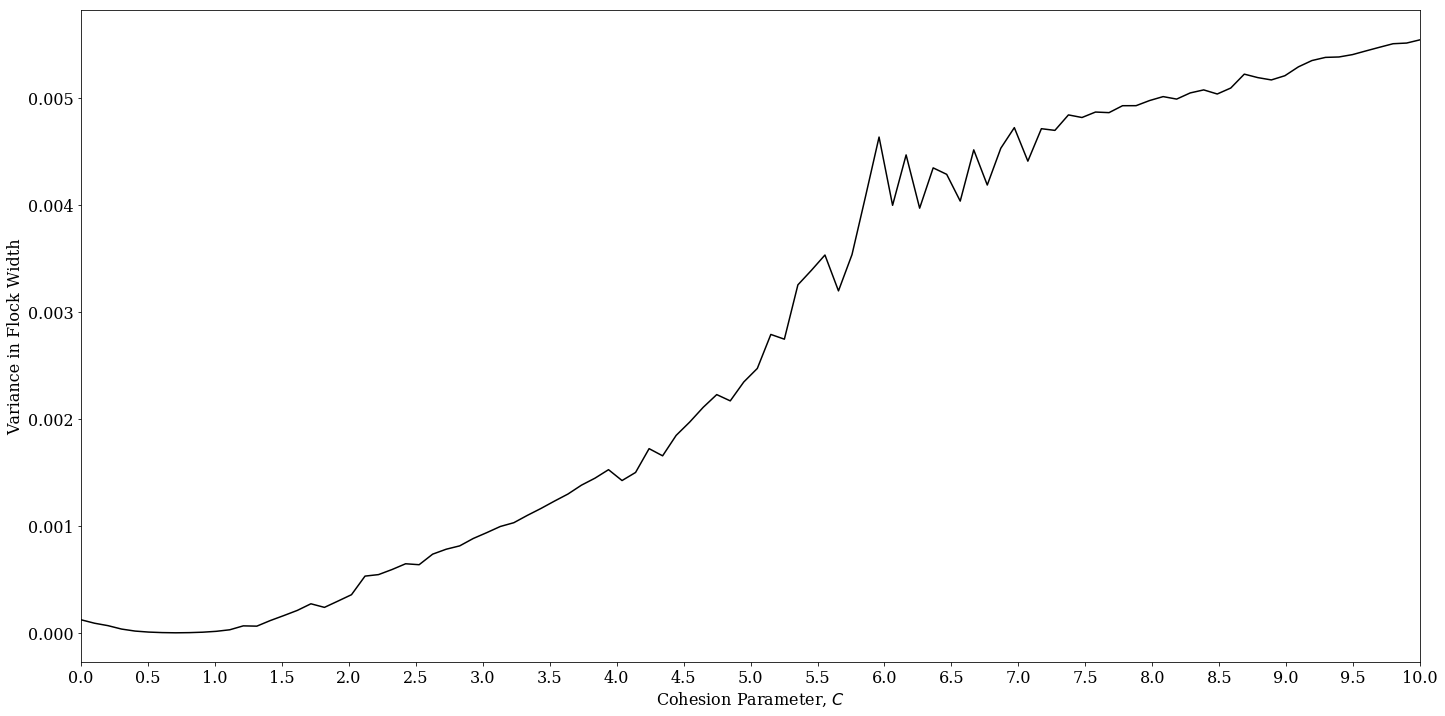

In [25]:
Cs = np.linspace(0, 10, 100)
var = np.zeros_like(Cs)
for i, C in enumerate(Cs):
    var[i] = training(C, training_loc, traning_vel, 50, 0.01)

plt.plot(Cs, var, 'k-') 
plt.xticks(np.arange(0, 10.5, 0.5))
plt.xlim(0, 10)
plt.xlabel('Cohesion Parameter, $C$')
plt.ylabel('Variance in Flock Width')
plt.show()

** Here, for n_steps = 50, dt = 0.01, the flock hasn't evolved for long enough, hence the strange shape of the curve. But, there is still a minimum between 0.5 - 1.0 which minimize_scalar would be able to find, but it may also find any one of the local minimums located at larger values of C.**

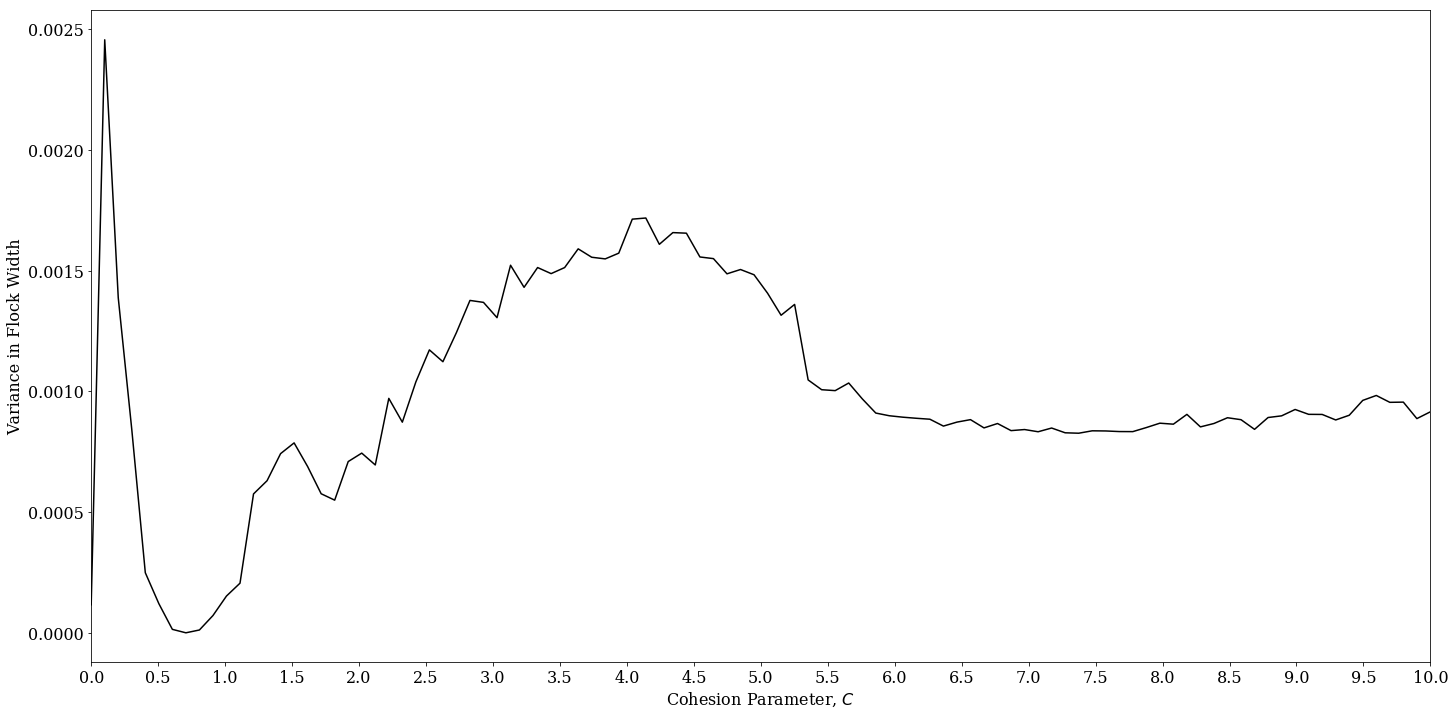

In [26]:
Cs = np.linspace(0, 10, 100)
var = np.zeros_like(Cs)
for i, C in enumerate(Cs):
    var[i] = training(C, training_loc, traning_vel, 500, 0.01)

plt.plot(Cs, var, 'k-') 
plt.xticks(np.arange(0, 10.5, 0.5))
plt.xlim(0, 10)
plt.xlabel('Cohesion Parameter, $C$')
plt.ylabel('Variance in Flock Width')
plt.show()

** For n_steps = 500 and dt = 0.01, there is now an odd hump introduced to the middle of the curve. There is a global minimum around 0.75 still, but when aplied to a flock, minimize_sclar found the local minimum at 7.69. This reiterates the point that to find the optimum value, it is a good idea to plot this curve and then define the bounds for optimisation. **

# Does the optimum value of C change with number of boids?

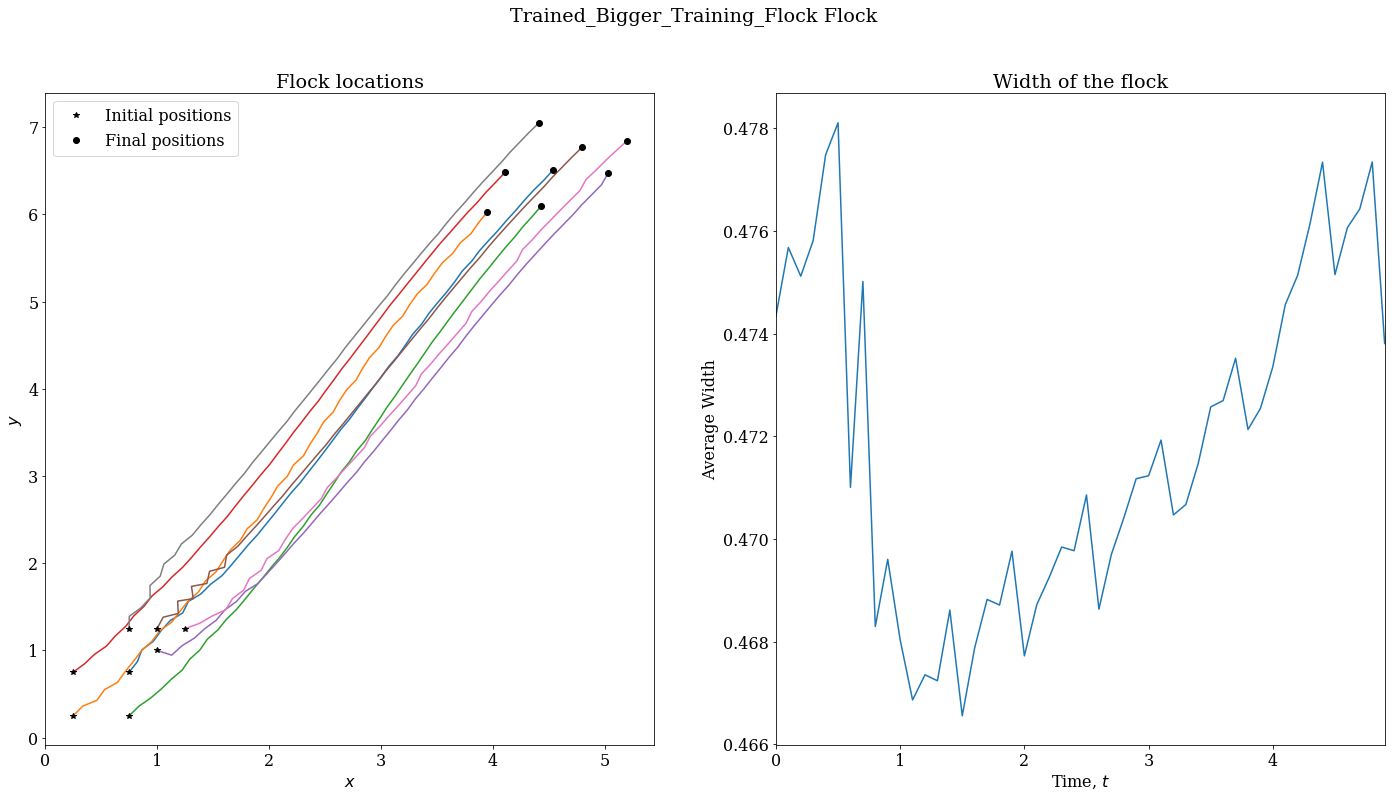

Value of cohesion parameter, C: 1.3347222497312923.
Variance of width: 1.0531e-05


In [27]:
boid_locations = np.array([[0.75, 0.75], [0.25, 0.25], [0.75, 0.25],
                           [0.25, 0.75], [1.00, 1.00], [1.00, 1.25],
                           [1.25, 1.25], [0.75, 1.25]])
boid_velocities = np.ones_like(boid_locations)

C = train_flock(boid_locations, boid_velocities, 50, 0.1)  
evolve_flock_and_plot(boid_locations, boid_velocities, 50, 0.1, C, 'Trained_Bigger_Training_Flock')
print("Variance of width: {:8.4e}".format(training(C, boid_locations, boid_velocities, 50, 0.1)))

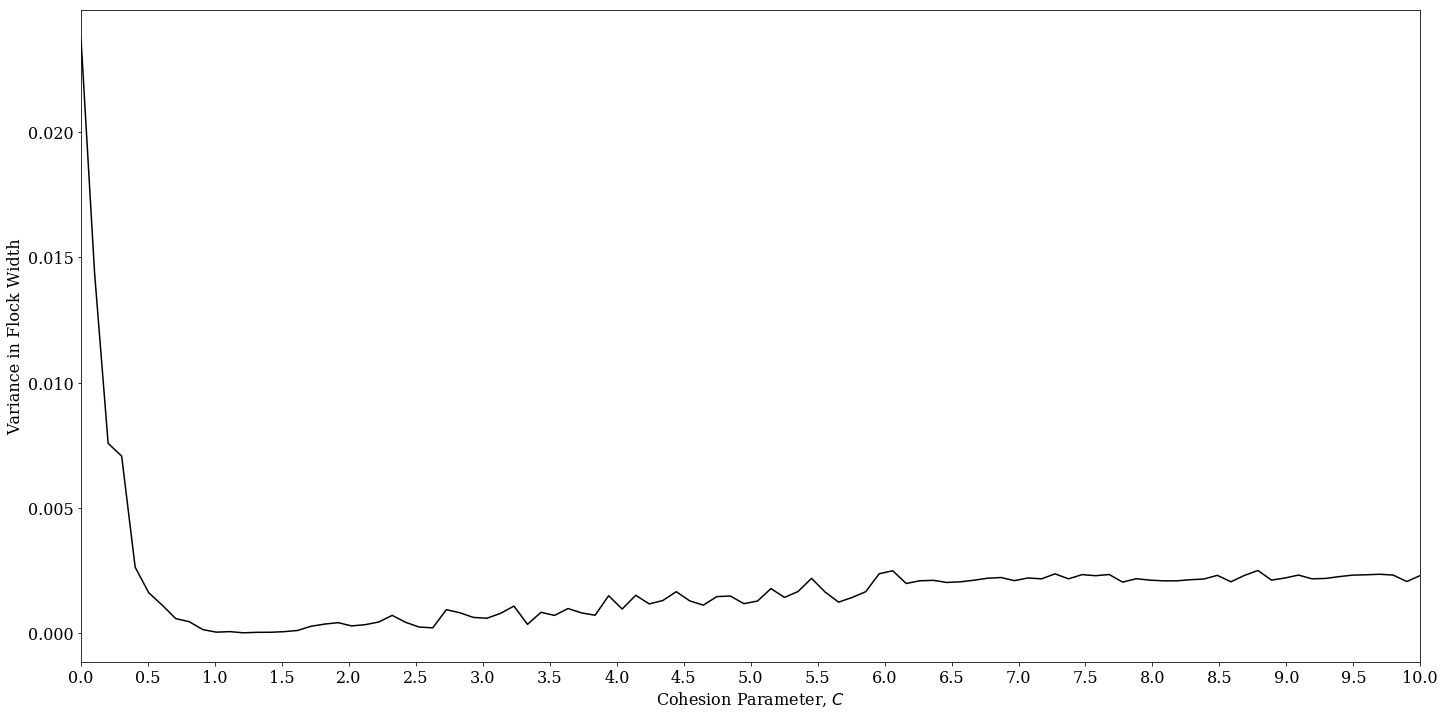

In [28]:
Cs = np.linspace(0, 10, 100)
var = np.zeros_like(Cs)
for i, C in enumerate(Cs):
    var[i] = training(C, boid_locations, boid_velocities, 50, 0.1)
    
plt.plot(Cs, var, 'k-') 
plt.xticks(np.arange(0, 10.5, 0.5))
plt.xlim(0, 10)
plt.xlabel('Cohesion Parameter, $C$')
plt.ylabel('Variance in Flock Width')
plt.show()

** Yes it does. This makes sense as you would expect the flock dynamics to change with the number of boids in the flock. The global minimum has moved slightly to the right on the curve, but not by much.**

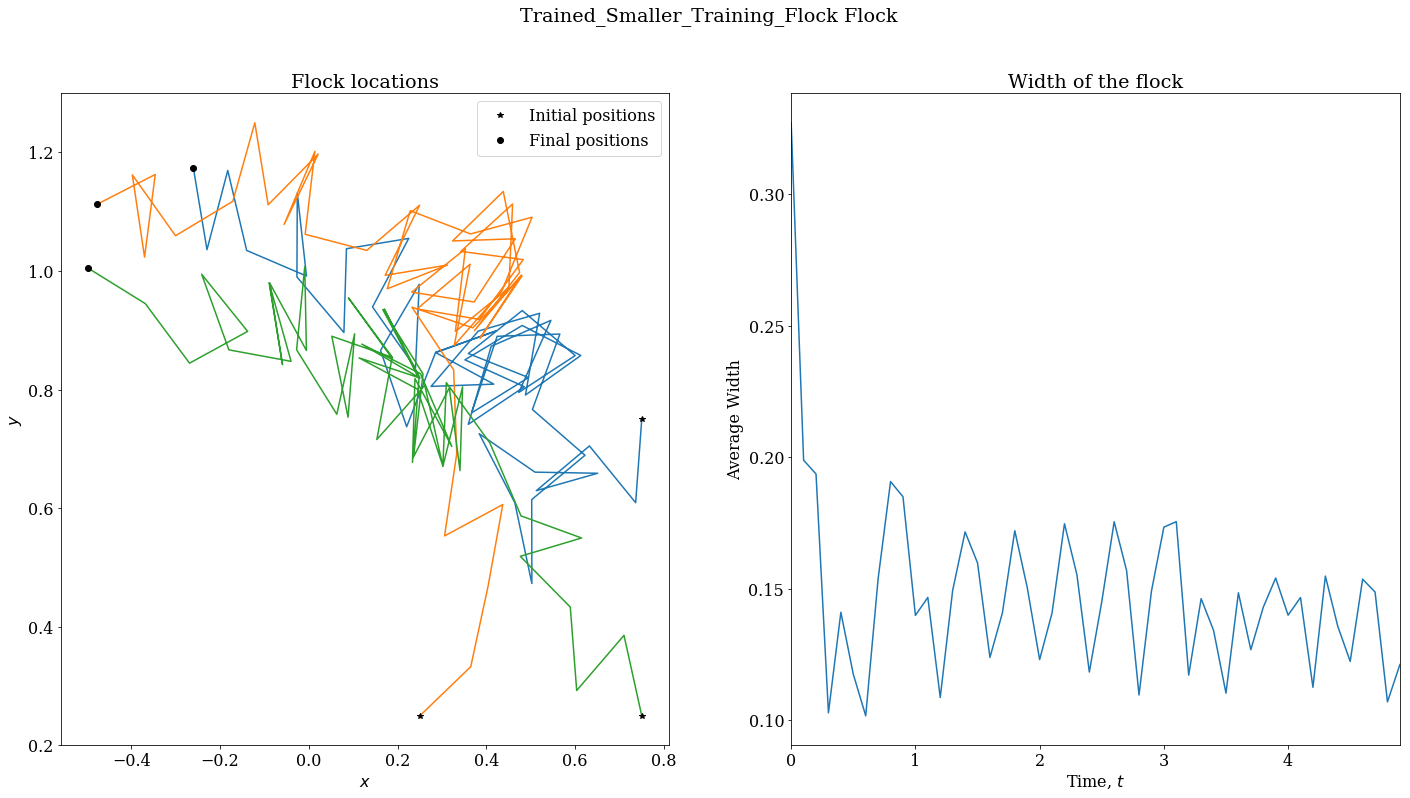

Value of cohesion parameter, C: 8.595375313283757.
Variance of width: 1.2463e-03


In [29]:
boid_locations = np.array([[0.75, 0.75], [0.25, 0.25], [0.75, 0.25]])
boid_velocities = np.ones_like(boid_locations)

C = train_flock(boid_locations, boid_velocities, 50, 0.1)  
evolve_flock_and_plot(boid_locations, boid_velocities, 50, 0.1, C, 'Trained_Smaller_Training_Flock')
print("Variance of width: {:8.4e}".format(training(C, boid_locations, boid_velocities, 50, 0.1)))

** Minimize_scalar finds a rather high value of C here, where it must have found a local minimum rather than the global. **

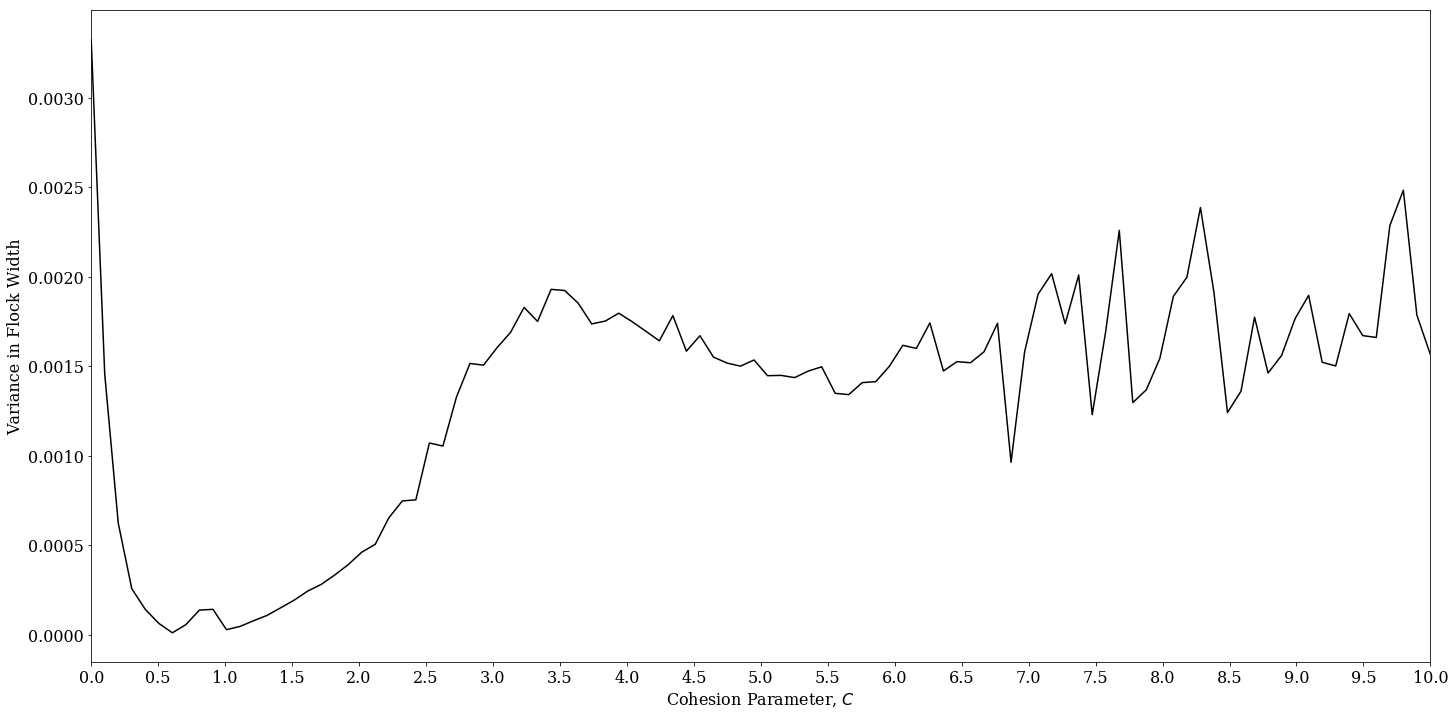

In [30]:
Cs = np.linspace(0, 10, 100)
var = np.zeros_like(Cs)
for i, C in enumerate(Cs):
    var[i] = training(C, boid_locations, boid_velocities, 50, 0.1)
    
plt.plot(Cs, var, 'k-') 
plt.xticks(np.arange(0, 10.5, 0.5))
plt.xlim(0, 10)
plt.xlabel('Cohesion Parameter, $C$')
plt.ylabel('Variance in Flock Width')
plt.show()

** Plotting the variance against C does show that minimize_scalar found a local minimum. The global minimum is  around 0.55. **

# Closing Remarks

** In general the global minimum of the function appears to remain mostly unchanged depending on the dynamics of the flock, i.e. the number of boids in the training flock or the time the resolution the flocked is evolved at. The found value of C will however change due to the minimizing function finding a local minimum to the function rather then the global minimum. Thus, it would be wise to first plot the function and then choose appropriate bounds to find the global minimum.**

** A final thing to do would be to plot a random flock which are generated closer together and then evolve this for a longer time to see if they stick together; this can take quite a long time.**

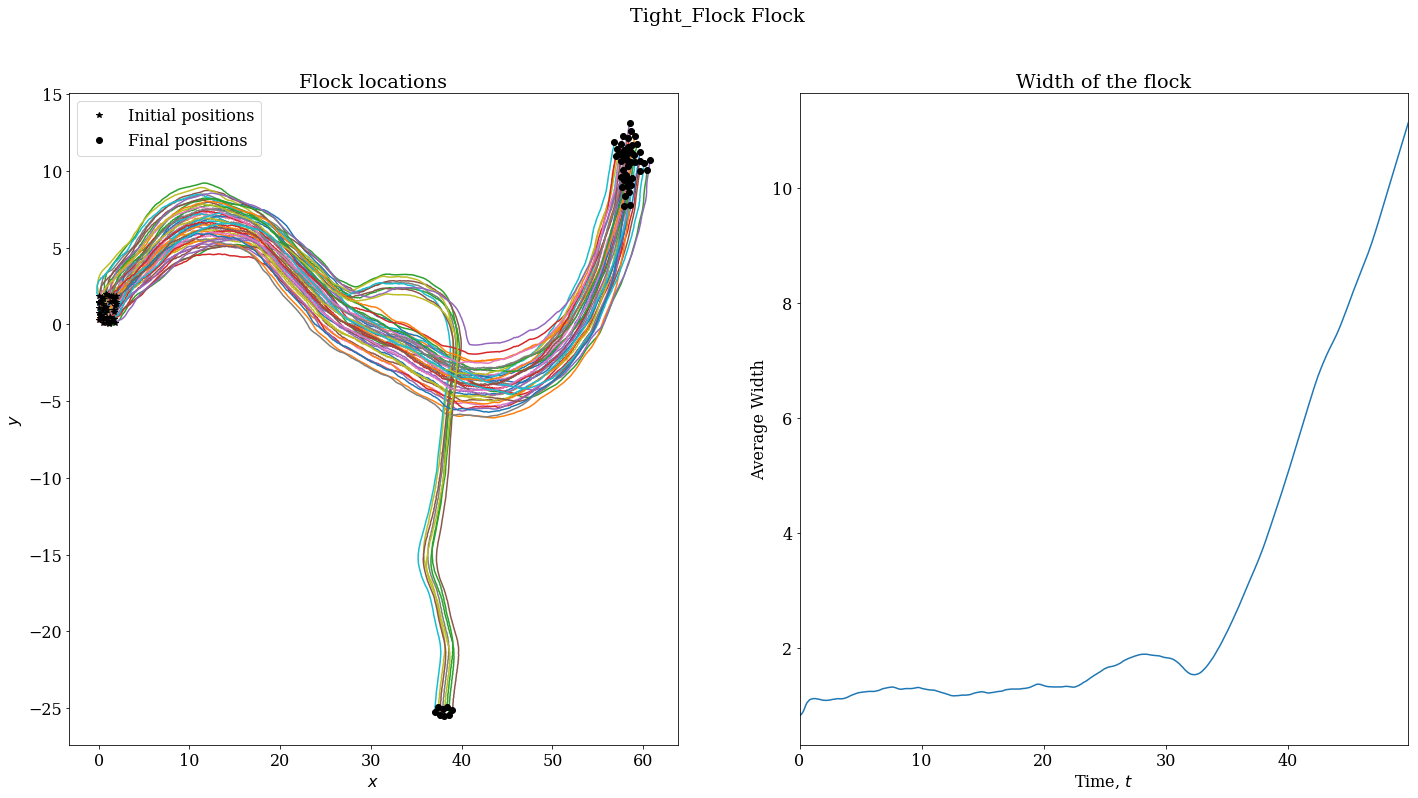

Value of cohesion parameter, C: 0.7589245141100489.


In [31]:
# generate a tighter initial flock
n_boids = 50
boid_locations = 2 * np.random.rand(n_boids, 2)
boid_velocities = np.ones_like(boid_locations) + 0.01 * \
    np.random.rand(n_boids, 2)
# set C as the minimum found
C = 0.7589245141100489  
# evolve and plot the flock!
evolve_flock_and_plot(boid_locations, boid_velocities, 500, 0.1, C, 'Tight_Flock')

** The flock sticks together until t ~ 32, where two flocks then form and split off and go their separate ways. This is probably due to the empty regions and the birds drifting towards their local flock. Using more boids would fill in these empty areas and I would expect the flock to stick together for longer. **


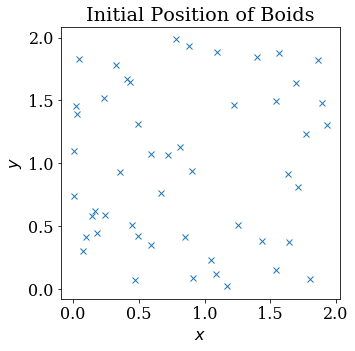

In [32]:
plt.figure(figsize=(5, 5))
plt.plot(boid_locations[:, 0], boid_locations[:, 1], 'x')
plt.title('Initial Position of Boids')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()

** So it appears the value of C found is reasonably good at keeping a flock together. **